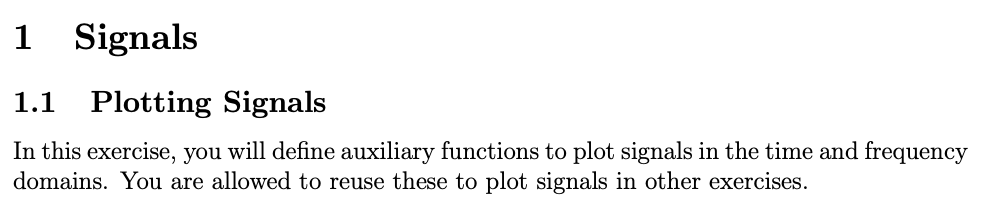

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.windows import dpss
from scipy.io import wavfile
from scipy.signal.windows import hann

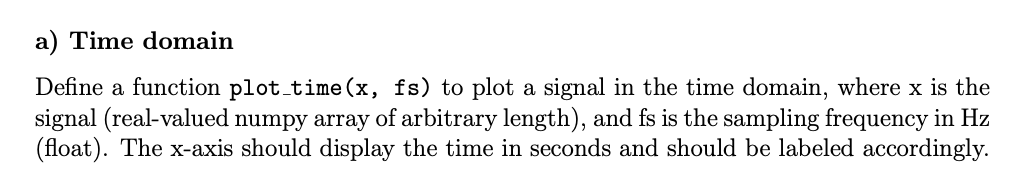

In [2]:
def plot_time(x, fs):
    n = len(x)
    t = np.arange(n) / fs

    plt.figure(figsize=(8,4))
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Signal in Time Domain')
    plt.plot(t, x)
    plt.grid()
    plt.show()

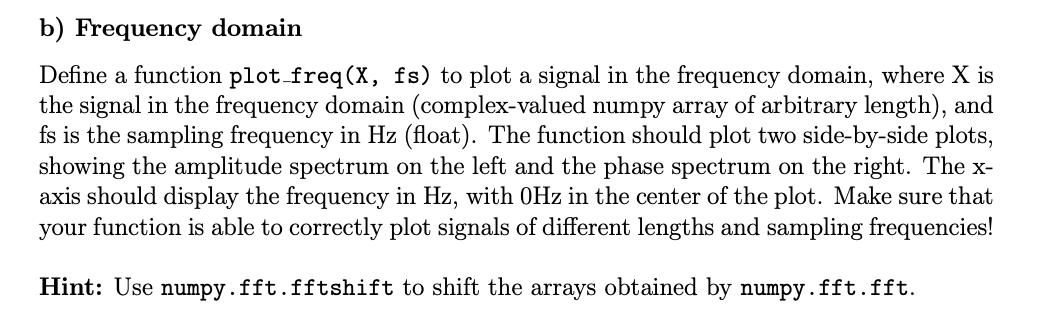

In [3]:
def plot_freq(X, fs):
    N = len(X)

    f = np.fft.fftfreq(N, 1/fs)
    f = np.fft.fftshift(f)

    X = np.fft.fftshift(X)
    
    amplitude = np.abs(X)
    phase = np.angle(X)

    threshold = 0.01
    phase[amplitude < threshold] = 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.plot(f, amplitude)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Amplitude Spectrum')
    ax1.grid()

    ax2.plot(f, phase)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (radians)')
    ax2.set_title('Phase Spectrum')
    ax2.grid()

    plt.tight_layout()
    plt.show()

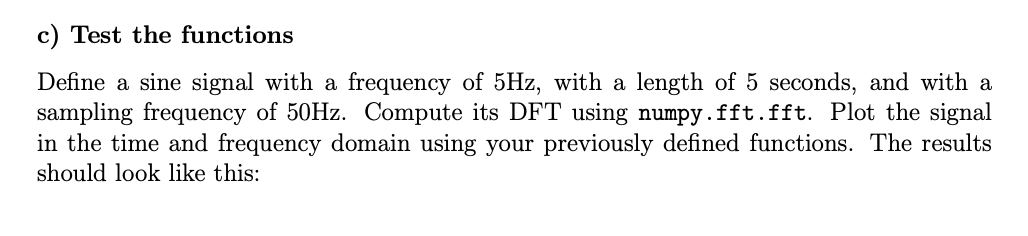

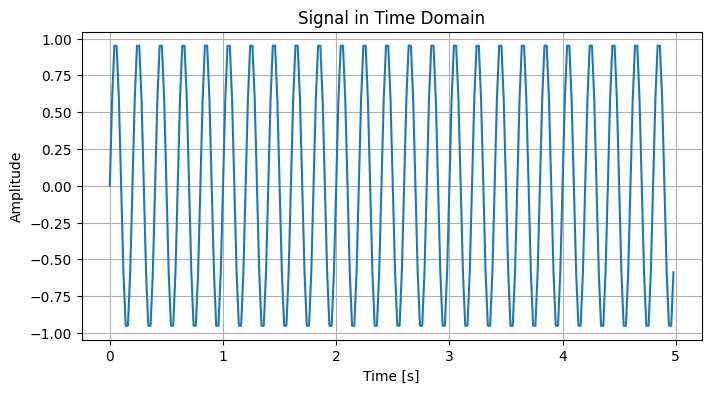

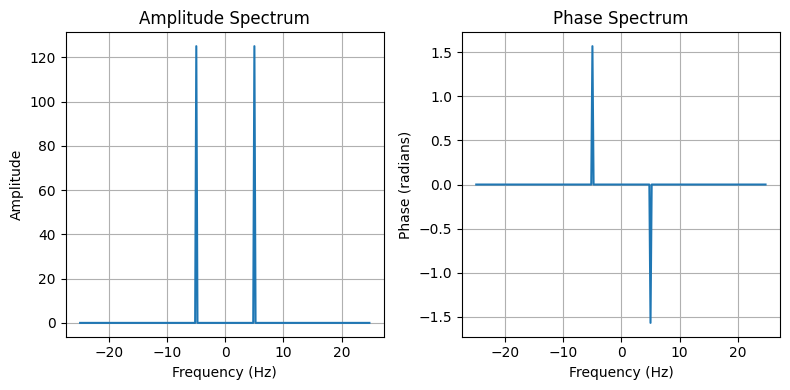

In [4]:
sin_freq = 5
T = 5
fs = 50

n = T * fs

t = np.arange(n) / fs

x = np.sin(2 * np.pi * sin_freq * t)

plot_time(x, fs)

X = np.fft.fft(x)

plot_freq(X, fs)

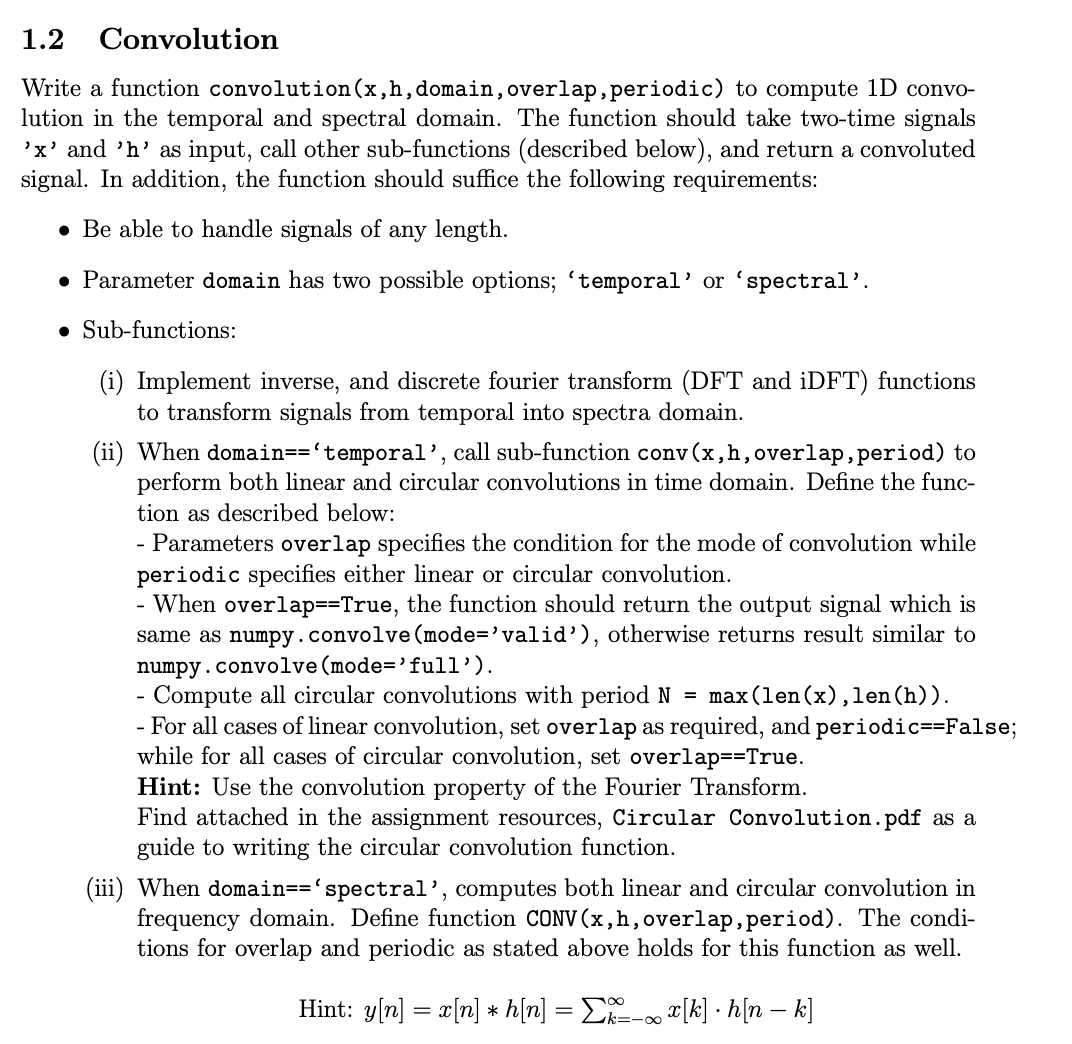

In [5]:
def convolution(x, h, domain, overlap, periodic):

    def DFT(x):
        N = len(x)

        X = np.zeros(N, dtype=complex)

        for k in range (N):
            for n in range (N):
                X[k] += x[n] * np.exp(-1j * 2 * np.pi * k * n / N)
        
        return X
    
    def iDFT(X):
        N = len(X)
        x = np.zeros(N, dtype=complex)

        for n in range (N):
            for k in range (N):
                x[n] += X[k] * np.exp(1j * 2 * np.pi * k * n / N)
            x[n] /= N
        
        return x
    
    def conv(x, h, overlap, period):
        if overlap and period:
            N = max(len(x), len(h))

            if len(x) < N:
                x = np.pad(x, (0, N - len(x)), mode='constant')
            if len(h) < N:
                h = np.pad(h, (0, N - len(h)), mode='constant')

            y = np.zeros(N)

            for n in range  (N):
                for m in range (len(h)):
                    y[n] += x[m] * h[(n-m) % N]
            return y
        
        elif overlap and not period:
            N= len(x) - len(h) + 1

            y = np.zeros(N)

            for n in range (N):
                for k in range (len(h)):
                    y[n] += x[n+k] * h[len(h)-1-k]
            return y
        
        elif not overlap and not period:
            N= len(x) + len(h) - 1

            y = np.zeros(N)

            for n in range (N):
                for k in range (len(x)):
                    if 0 <= n-k < len(h):
                        y[n] += x[k] * h[n-k]
            return y
        
        else:
            raise ValueError("Invalid combination of overlap and periodicity options.")
        
    def CONV(x, h, overlap, period):
        if overlap and period:
            N = max(len(x), len(h))
            x = np.pad(x, (0, N - len(x)), mode='constant')
            h = np.pad(h, (0, N - len(h)), mode='constant')
        
        elif not overlap and not period:
            N = len(x) + len(h) -1
            x = np.pad(x, (0, N - len(x)), mode='constant')
            h = np.pad(h, (0, N - len(h)), mode='constant')
        
        else:
            raise ValueError("Invalid combination of overlap and periodicity options.")
        
        X = DFT(x)
        H = DFT(h)

        Y = np.zeros(N, dtype=complex)

        for k in range  (N):
            Y[k] = X[k] * H[k]

        y = iDFT(Y)

        return y.real
    
    if domain == 'temporal':
        return conv(x, h, overlap, periodic)
    elif domain == 'spectral':
        return CONV(x, h, overlap, periodic)
    else:
        raise ValueError("Invalid domain specified. Use 'temporal' or 'spectral'.")

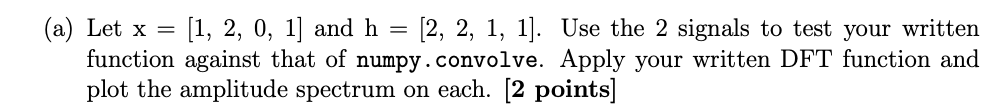

In [6]:
x = np.array([1, 2, 0, 1])
h = np.array([2, 2, 1, 1])

y_exercise = convolution(x, h, 'temporal', False, False)
print("Convolution result (temporal domain)     :", y_exercise)

y_np = np.convolve(x, h, mode='full')
print("Convolution result (numpy)               :", y_np)

print("Do the results match?                ans.:", np.allclose(y_exercise, y_np))

Convolution result (temporal domain)     : [2. 6. 5. 5. 4. 1. 1.]
Convolution result (numpy)               : [2 6 5 5 4 1 1]
Do the results match?                ans.: True


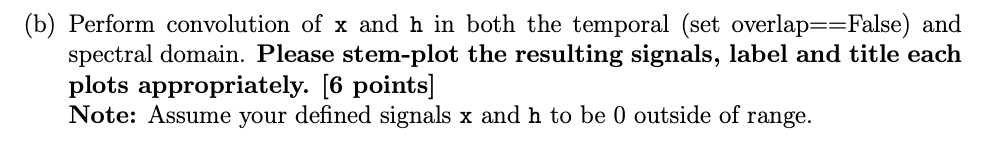

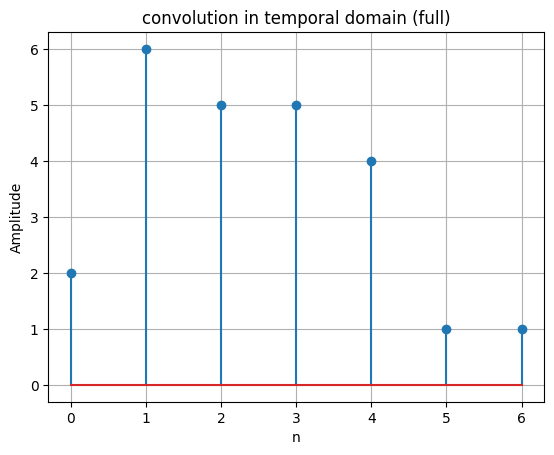

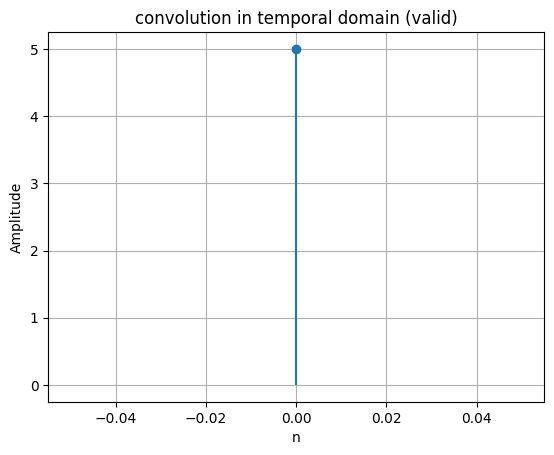

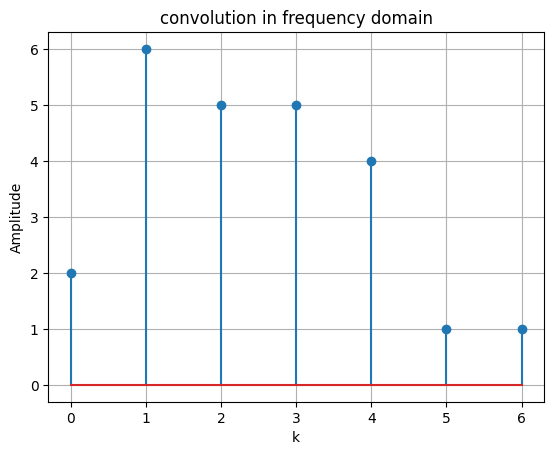

In [7]:
y_temporal_full = convolution(x, h, 'temporal', False, False)
y_temporal_valid = y_temporal = convolution(x, h, 'temporal', True, False)

y_spectral = convolution(x, h, 'spectral', False, False)

plt.stem(y_temporal_full)
plt.title('convolution in temporal domain (full)')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.stem(y_temporal_valid)
plt.title('convolution in temporal domain (valid)')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.stem(y_spectral)
plt.title('convolution in frequency domain')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

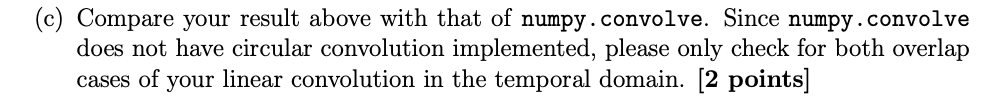

In [8]:
y_np_temporal_full  = np.convolve(x, h, mode='full')
y_np_temporal_valid = np.convolve(x, h, mode='valid')

print("The differences between the linear full convolution using the custom function and numpy are      :", y_temporal_full - y_np_temporal_full)
print("The differences between the linear valid convolution using the custom function and numpy are     :", y_np_temporal_valid - y_np_temporal_valid)

print("Does the custom function match the numpy results for full convolution?                   ans.    :", np.allclose(y_temporal_full, y_np_temporal_full))
print("Does the custom function match the numpy results for valid convolution?                  ans.    :", np.allclose(y_temporal_valid, y_np_temporal_valid))

The differences between the linear full convolution using the custom function and numpy are      : [0. 0. 0. 0. 0. 0. 0.]
The differences between the linear valid convolution using the custom function and numpy are     : [0]
Does the custom function match the numpy results for full convolution?                   ans.    : True
Does the custom function match the numpy results for valid convolution?                  ans.    : True


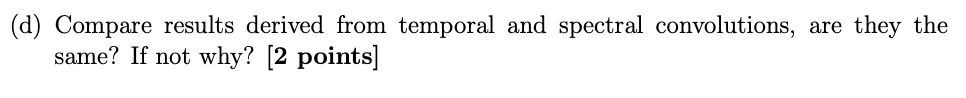

In [9]:
print("The results of temoral and spectal convolution match?      ans.:", np.allclose(y_temporal_full, y_spectral))

The results of temoral and spectal convolution match?      ans.: True


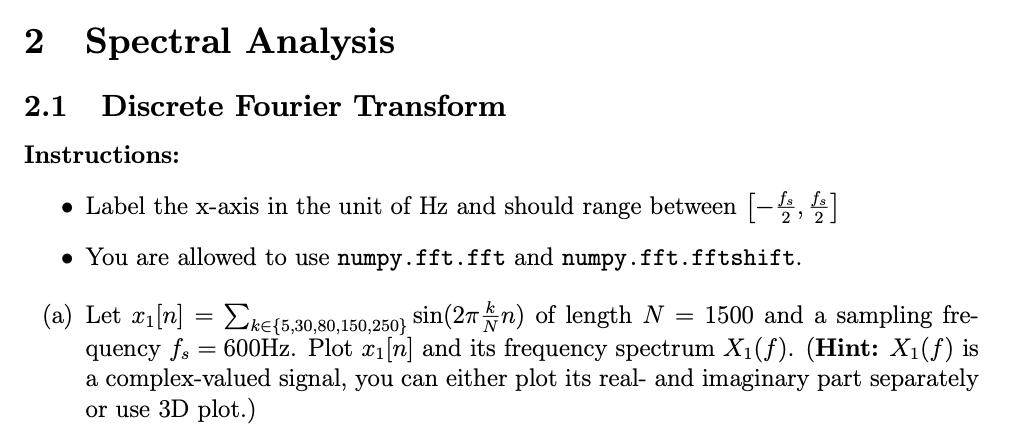

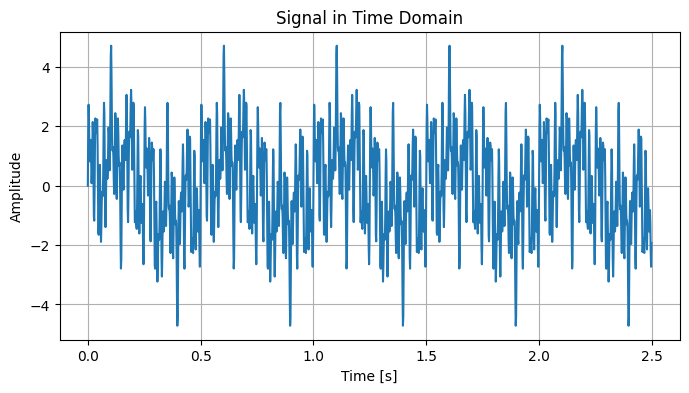

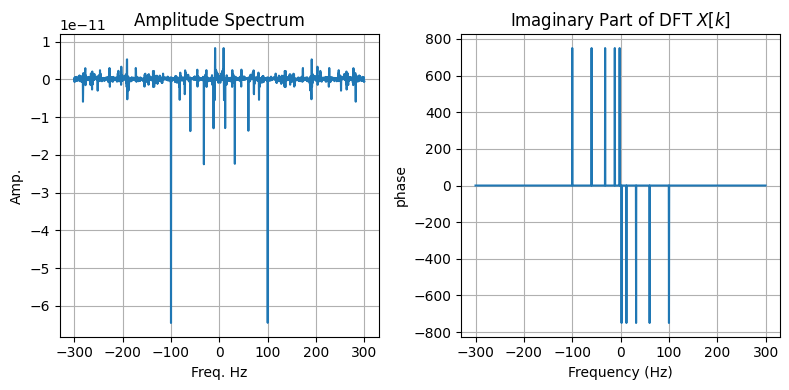

In [10]:
N = 1500
fs = 600
n = np.arange(N)

ks = [5, 30, 80, 150, 250]

x1 = np.zeros(N)

for k in ks:
    x1 += np.sin(2 * np.pi * k / N * n)

plot_time(x1, fs)

X1 = np.fft.fftshift(np.fft.fft(x1))
f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(f, X1.real)
ax1.set_xlabel('Freq. Hz')
ax1.set_ylabel('Amp.')
ax1.set_title('Amplitude Spectrum')
ax1.grid()

ax2.plot(f, X1.imag)
ax2.set_title('Imaginary Part of DFT $X[k]$')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('phase')
ax2.grid()

plt.tight_layout()
plt.show()


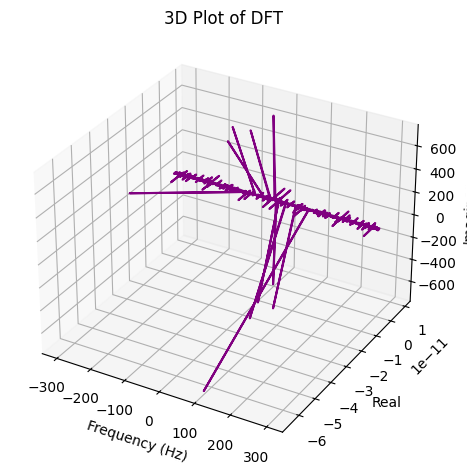

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(f, X1.real, X1.imag, color='purple')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.set_title('3D Plot of DFT')
ax.grid(True)

plt.tight_layout()
plt.show()

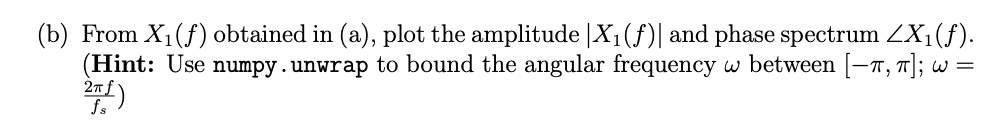

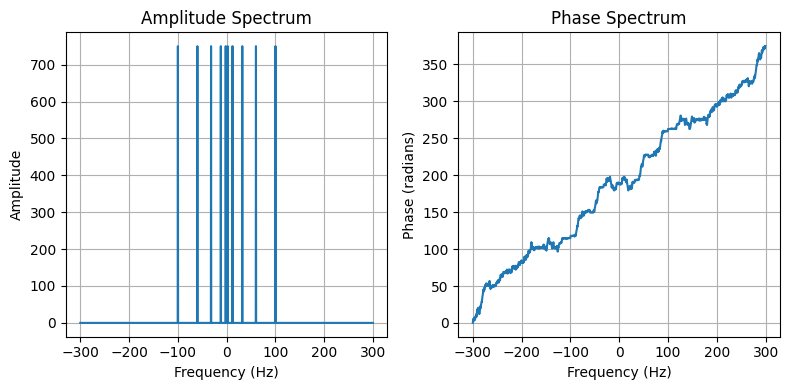

In [12]:
amplitude = np.abs(X1)
phase = np.unwrap(np.angle(X1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(f, amplitude)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude Spectrum')
ax1.grid()

ax2.plot(f, phase)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase Spectrum')
ax2.grid()

plt.tight_layout()
plt.show()

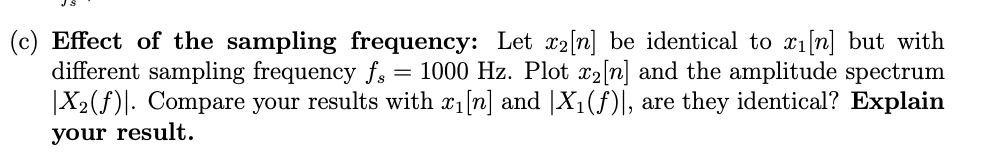

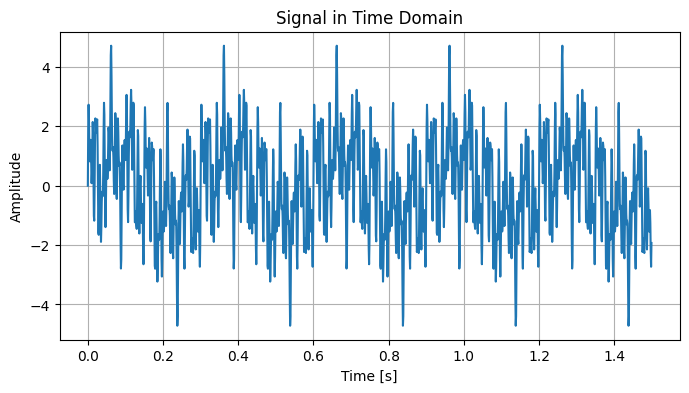

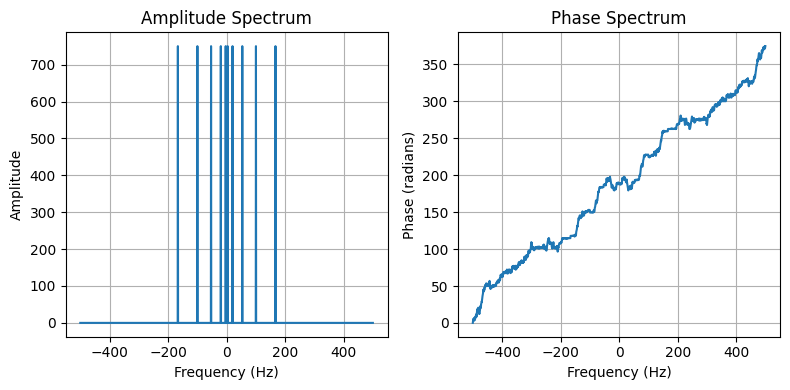

In [13]:
fs = 1000
x2 = x1

f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))

X2 = np.fft.fftshift(np.fft.fft(x2))

plot_time(x2, fs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(f, np.abs(X2))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude Spectrum')
ax1.grid()

ax2.plot(f, np.unwrap(np.angle(X2)))
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase Spectrum')
ax2.grid()

plt.tight_layout()
plt.show()


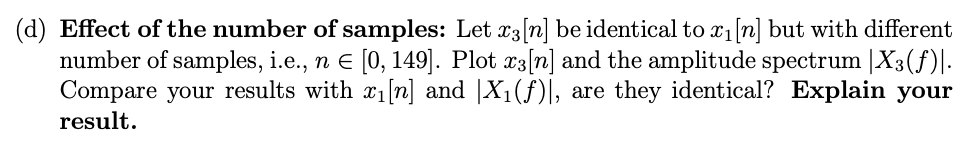

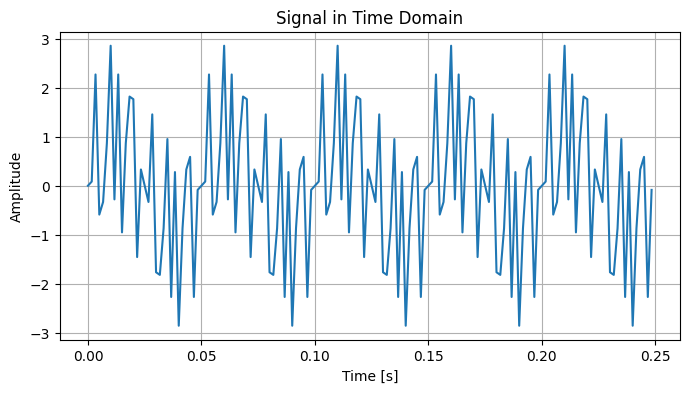

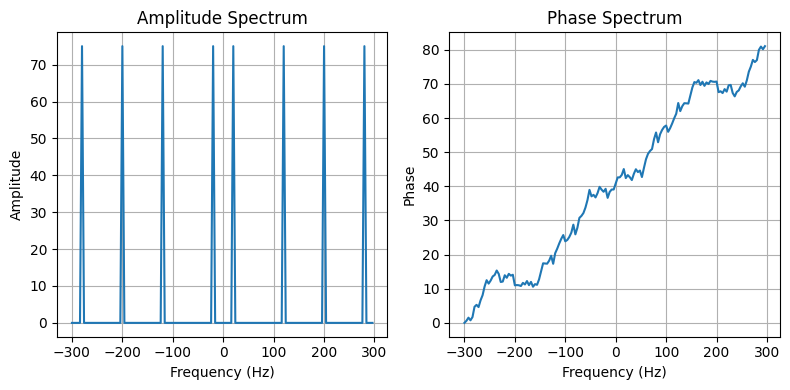

In [14]:
N = 150
fs = 600
n = np.arange(N)

x3 = np.zeros(N)

for k in ks:
    x3 += np.sin(2 * np.pi * k / N * n)

plot_time(x3, fs)

X3 = np.fft.fftshift(np.fft.fft(x3))
f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(f, np.abs(X3))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude Spectrum')
ax1.grid()

ax2.plot(f, np.unwrap(np.angle(X3)))
ax2.set_title('Phase Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase')
ax2.grid()

plt.tight_layout()
plt.show()

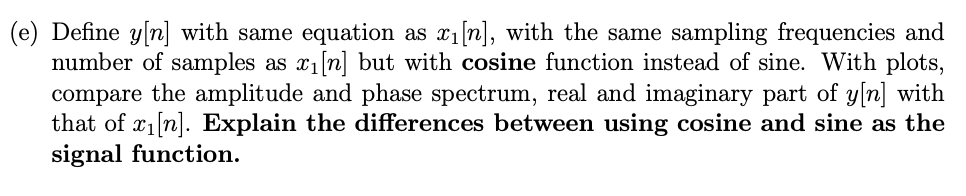

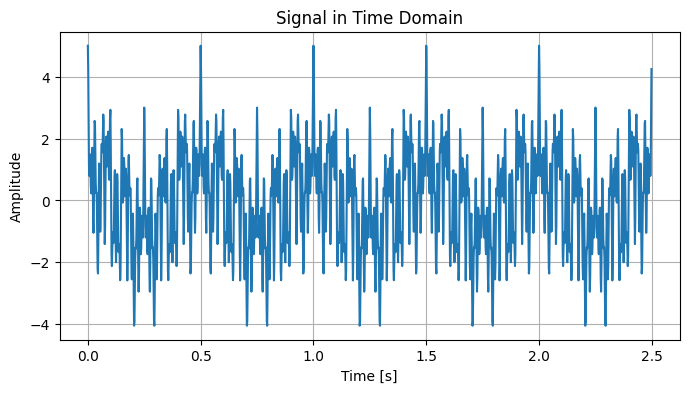

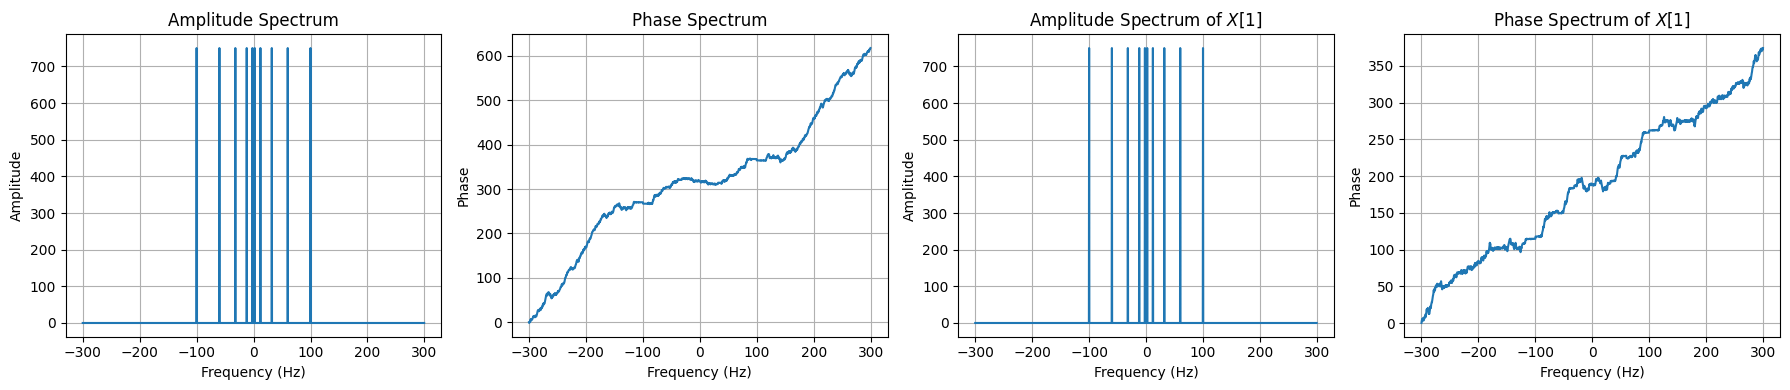

In [15]:
N = 1500
fs = 600
n = np.arange(N)

y = np.zeros(N)

for k in ks:
    y += np.cos(2 * np.pi * k / N * n)

plot_time(y, fs)

Y = np.fft.fftshift(np.fft.fft(y))
f = np.fft.fftshift(np.fft.fftfreq(N, 1/fs))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))
ax1.plot(f, np.abs(Y))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude Spectrum')
ax1.grid()

ax2.plot(f, np.unwrap(np.angle(Y)))
ax2.set_title('Phase Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase')
ax2.grid()

ax3.plot(f, np.abs(X1))
ax3.set_title('Amplitude Spectrum of $X[1]$')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude')
ax3.grid()

ax4.plot(f, np.unwrap(np.angle(X1)))
ax4.set_title('Phase Spectrum of $X[1]$')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Phase')
ax4.grid()

plt.tight_layout()
plt.show()

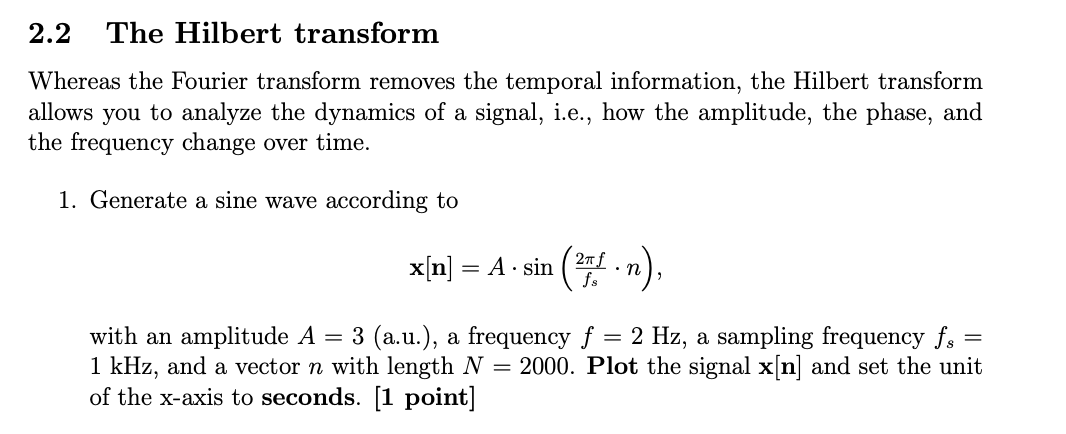

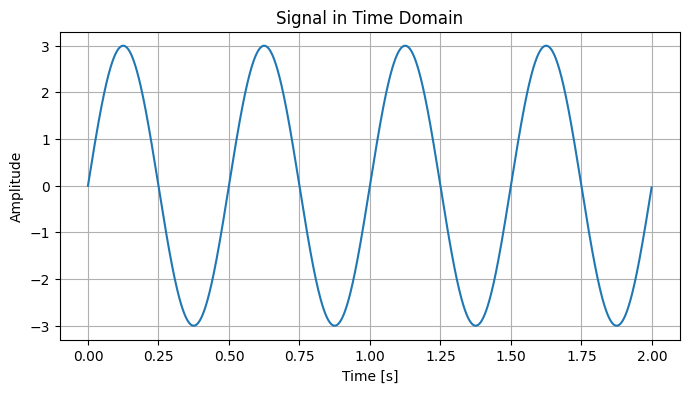

In [16]:
A = 3
f = 2
fs = 1000
N = 2000
n = np.arange(N)

x = A * np.sin(2 * np.pi * f / fs * n)

plot_time(x, fs)

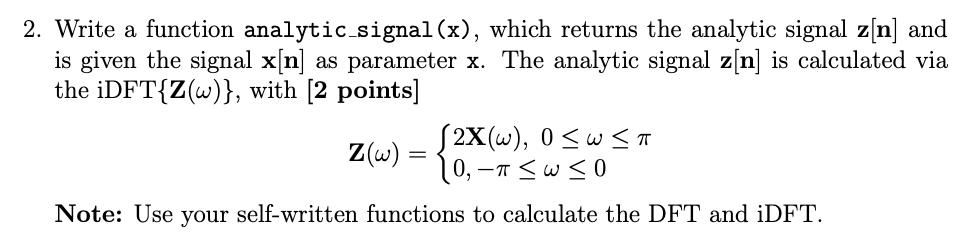

In [17]:
def DFT(x):
    N = len(x)

    X = np.zeros(N, dtype=complex)

    for k in range (N):
        for n in range (N):
            X[k] += x[n] * np.exp(-1j * 2 * np.pi * k * n / N)
    
    return X

def iDFT(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)

    for n in range (N):
        for k in range (N):
            x[n] += X[k] * np.exp(1j * 2 * np.pi * k * n / N)
        x[n] /= N
    
    return x

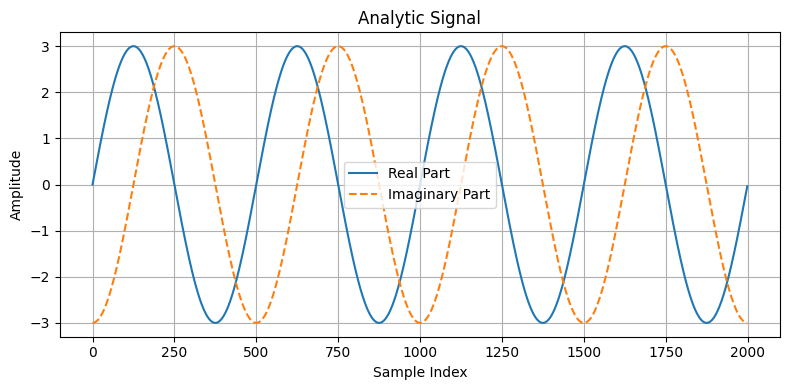

In [18]:
def analytic_signal(x):
    N = len(x)

    X = DFT(x)
    Z = np.zeros(N, dtype=complex)

    if N % 2 == 0:
        Z[0] = X[0]
        Z[1:N//2] = 2 * X[1:N//2]
        Z[N//2] = X[N//2]
        Z[N//2+1:] = 0
    else:
        Z[0] = X[0]
        Z[1:(N+1)//2] = 2 * X[1:(N+1)//2]
        Z[(N+1)//2:] = 0

    z = iDFT(Z)

    return z

z = analytic_signal(x)

plt.figure(figsize=(8, 4))
plt.plot(np.real(z), label='Real Part')
plt.plot(np.imag(z), label='Imaginary Part', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Analytic Signal')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

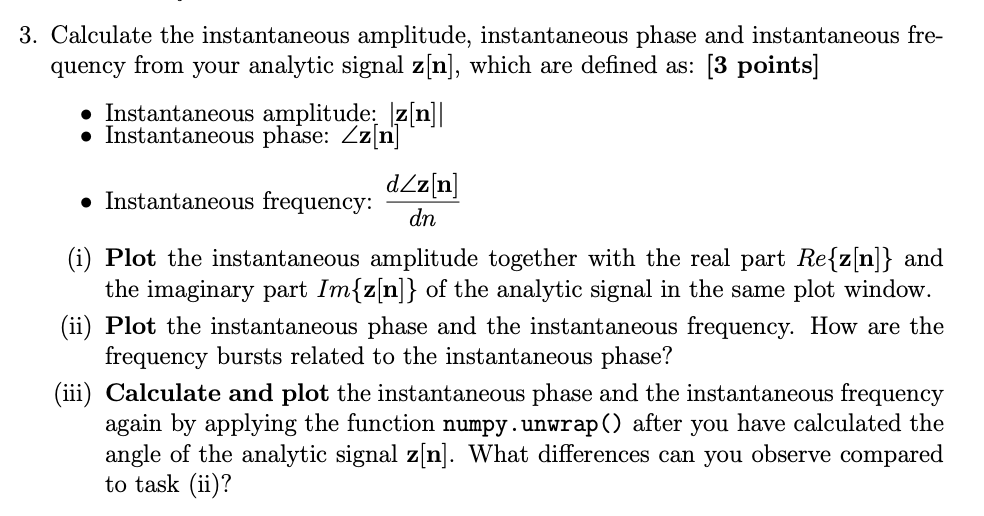
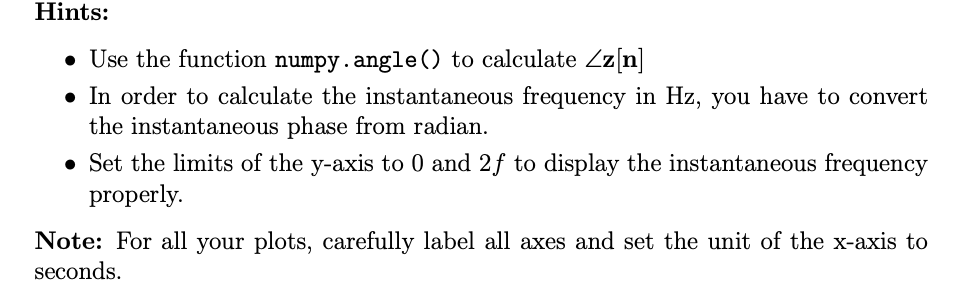

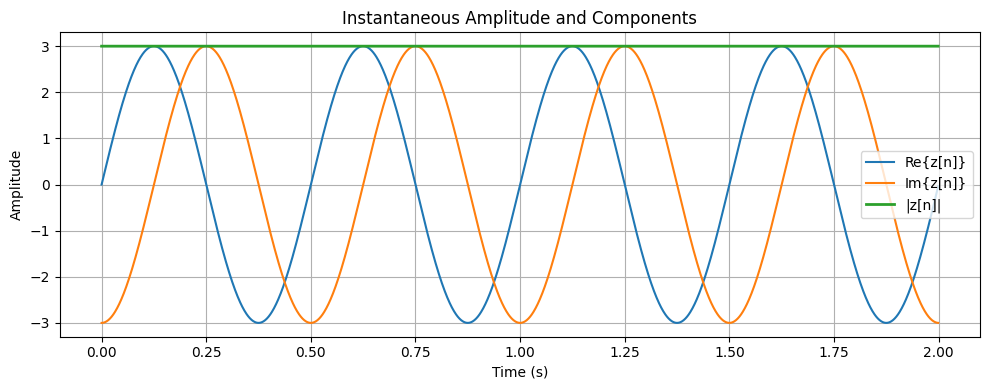

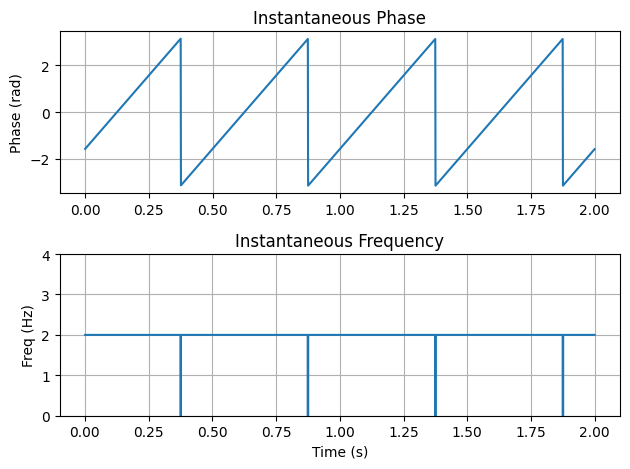

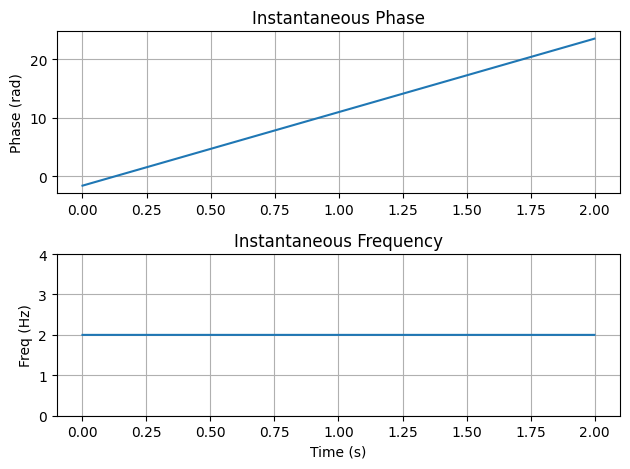

In [19]:
ins_amp = np.abs(z)
ins_phase = np.angle(z)
ins_freq = np.diff(ins_phase) / (2*np.pi) * fs

# i)
t = np.arange(len(z)) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, np.real(z), label='Re{z[n]}')
plt.plot(t, np.imag(z), label='Im{z[n]}')
plt.plot(t, ins_amp, label='|z[n]|', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Instantaneous Amplitude and Components')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ii)
plt.subplot(2, 1, 1)
plt.plot(t, ins_phase)
plt.title('Instantaneous Phase')
plt.ylabel('Phase (rad)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[1:], ins_freq)
plt.title('Instantaneous Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')
plt.ylim([0, 2*f])
plt.grid()

plt.tight_layout()
plt.show()

# iii)
ins_phase = np.unwrap(np.angle(z))
ins_freq = np.diff(ins_phase) / (2*np.pi) * fs

plt.subplot(2, 1, 1)
plt.plot(t, ins_phase)
plt.title('Instantaneous Phase')
plt.ylabel('Phase (rad)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[1:], ins_freq)
plt.title('Instantaneous Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')
plt.ylim([0, 2*f])
plt.grid()

plt.tight_layout()
plt.show()

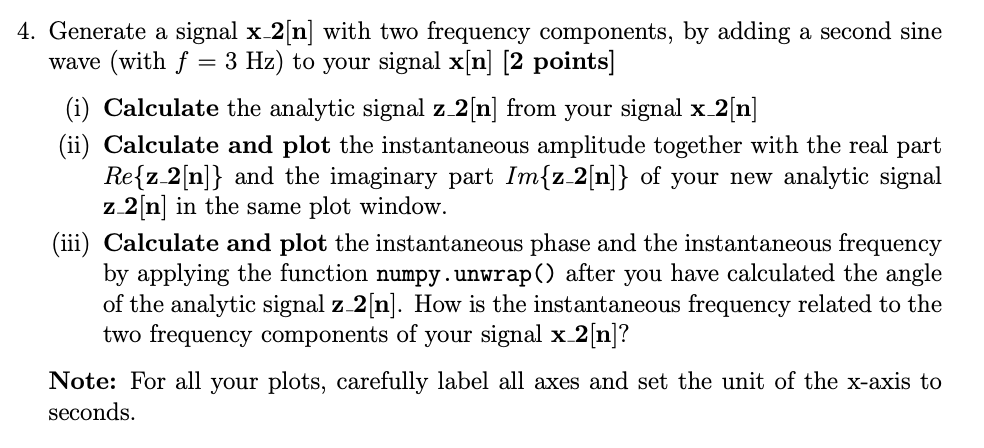

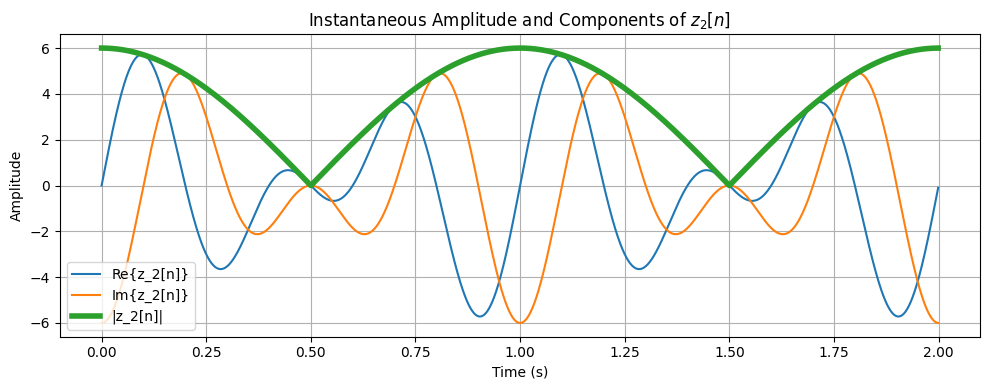

In [20]:
A = 3
f1 = 2
f2 = 3
fs = 1000
N = 2000
n = np.arange(N)

x_2 = A * np.sin(2 * np.pi * f1 / fs * n) + A * np.sin(2 * np.pi * f2 / fs * n)

z_2 = analytic_signal(x_2)

ins_amp = np.abs(z_2)
t = np.arange(len(z_2)) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, np.real(z_2), label='Re{z_2[n]}')
plt.plot(t, np.imag(z_2), label='Im{z_2[n]}')
plt.plot(t, ins_amp, label='|z_2[n]|', linewidth=4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Instantaneous Amplitude and Components of $z_2[n]$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

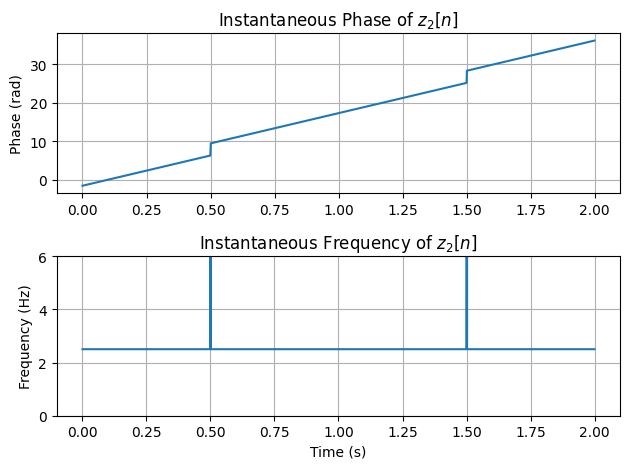

In [21]:
ins_phase = np.unwrap(np.angle(z_2))
ins_freq = np.diff(ins_phase) / (2*np.pi) * fs

plt.subplot(2, 1, 1)
plt.plot(t, ins_phase)
plt.title('Instantaneous Phase of $z_2[n]$')
plt.ylabel('Phase (rad)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[1:], ins_freq)
plt.title('Instantaneous Frequency of $z_2[n]$')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 2*f2])
plt.grid()

plt.tight_layout()
plt.show()

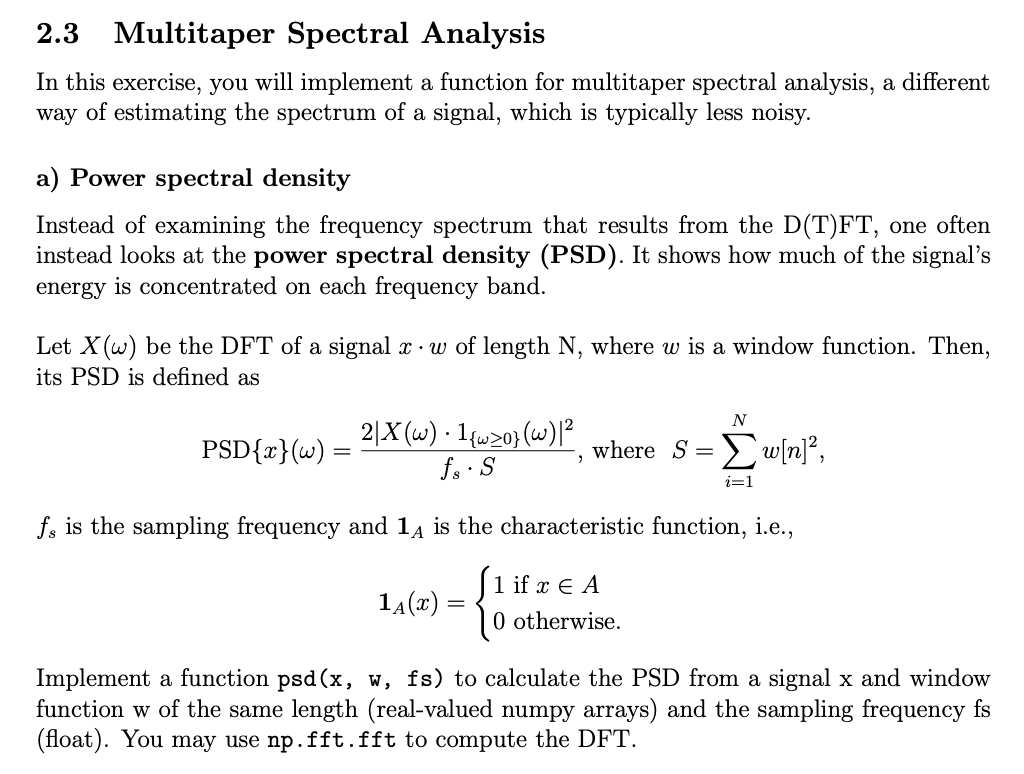

In [22]:
def psd(x, w, fs):
    xw = x * w

    X = np.fft.fft(xw)

    S = np.sum(w ** 2)

    N = len(X)

    PSD = 2 * np.abs(X) ** 2 / (fs * S)

    PSD[N//2+1:] = 0  # Remove negative frequencies

    PSD = np.fft.fftshift(PSD)
    
    return PSD

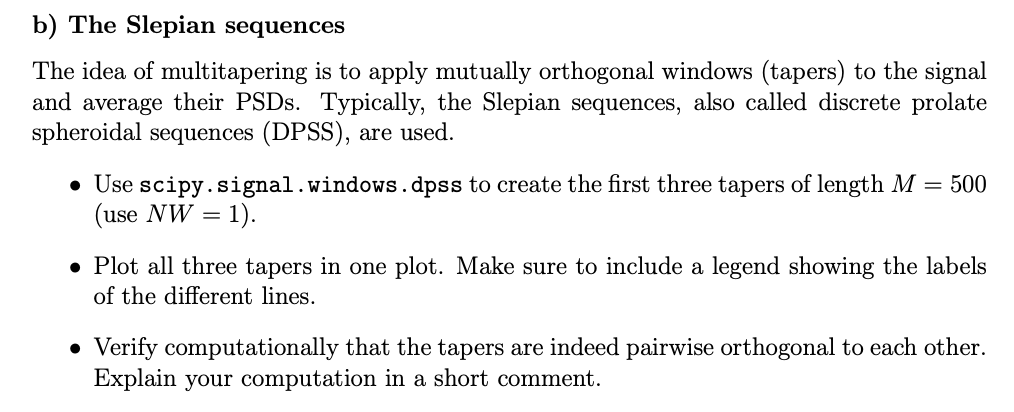

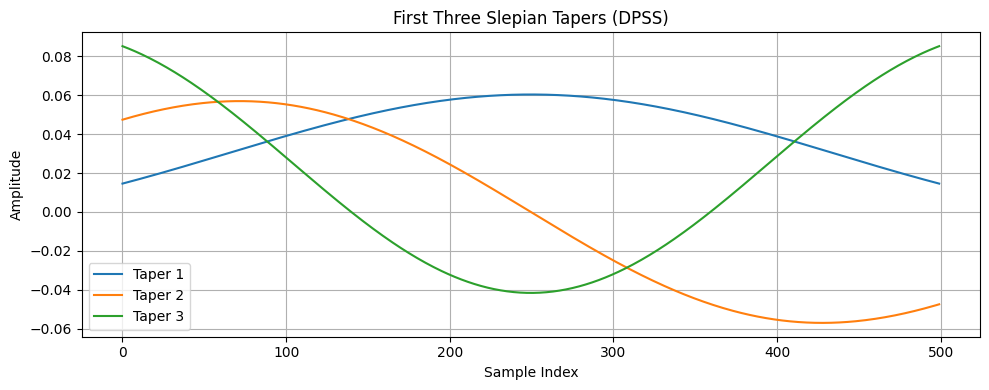

Dot products: 1.691355389077387e-17 -1.8756697583999227e-17 -2.2551405187698492e-17


In [23]:
M = 500
NW = 1
tapers = dpss(M, NW, Kmax=3)

plt.figure(figsize=(10, 4))
for i in range(3):
    plt.plot(tapers[i], label=f'Taper {i+1}')
plt.title('First Three Slepian Tapers (DPSS)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Orthogonality check:
dot_01 = np.dot(tapers[0], tapers[1])
dot_02 = np.dot(tapers[0], tapers[2])
dot_12 = np.dot(tapers[1], tapers[2])
print("Dot products:", dot_01, dot_02, dot_12)

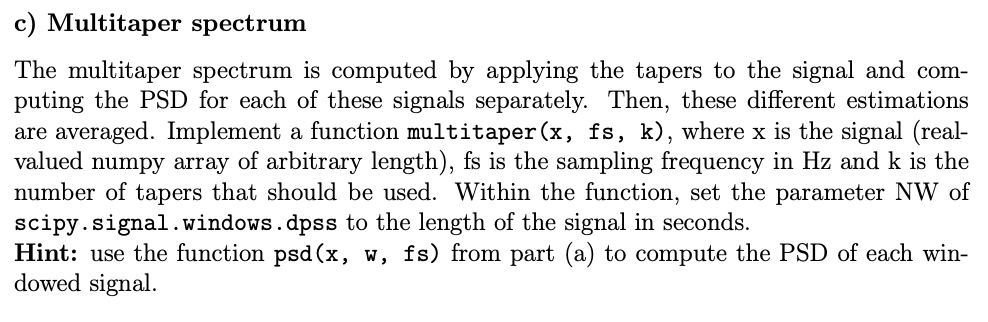

In [24]:
def multitaper(x, fs, k):
    N = len(x)

    tapers = dpss(N, NW=1, Kmax=k)

    psd_sum = np.zeros(N)

    for w in tapers:
        psd_sum += psd(x, w, fs)

    f = np.fft.fftshift(np.fft.fftfreq(N, d=1/fs))

    return psd_sum / k, f

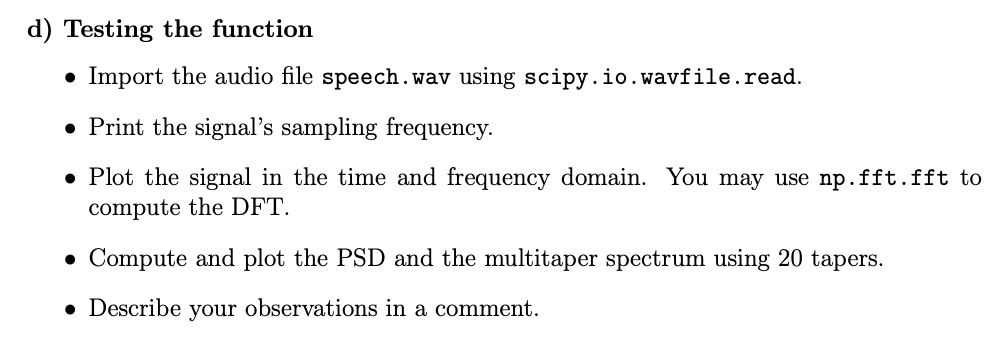

In [25]:
fs, x = wavfile.read("speech.wav")

print("Sampling frequency:", fs)

Sampling frequency: 48000


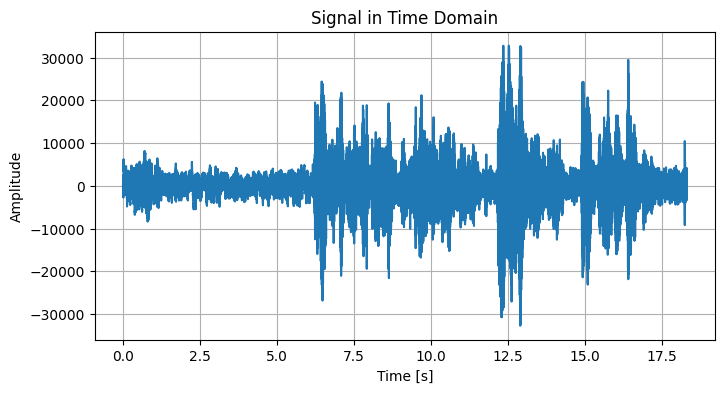

In [26]:
plot_time(x, fs)

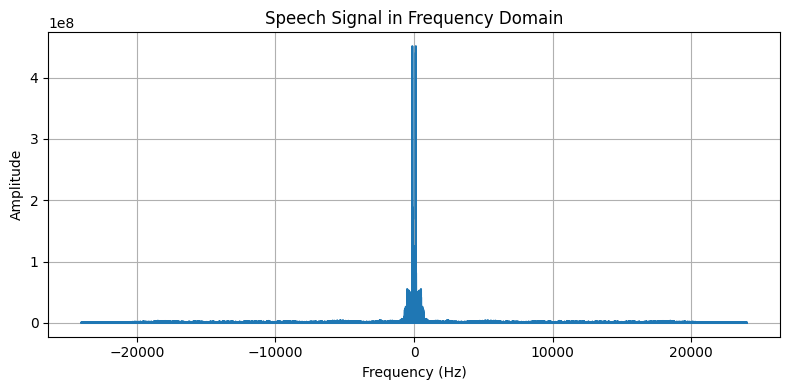

In [27]:
X = np.fft.fftshift(np.fft.fft(x))
f = np.fft.fftshift(np.fft.fftfreq(len(x), d=1/fs))

plt.figure(figsize=(8, 4))
plt.plot(f, np.abs(X))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Speech Signal in Frequency Domain')
plt.grid()
plt.tight_layout()
plt.show()

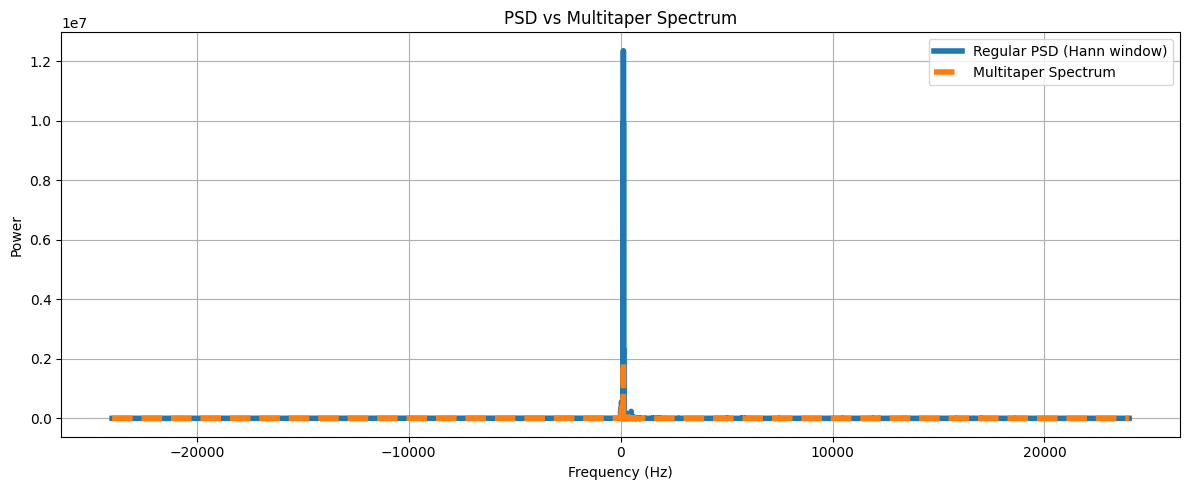

In [28]:
# hann
w = hann(len(x))
P_psd = psd(x, w, fs)

# multitaper
P_mt, f_mt = multitaper(x, fs, 20)

plt.figure(figsize=(12, 5))
plt.plot(f, P_psd, label='Regular PSD (Hann window)', linewidth=4)
plt.plot(f_mt, P_mt, label='Multitaper Spectrum', linestyle='--', linewidth=4)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('PSD vs Multitaper Spectrum')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

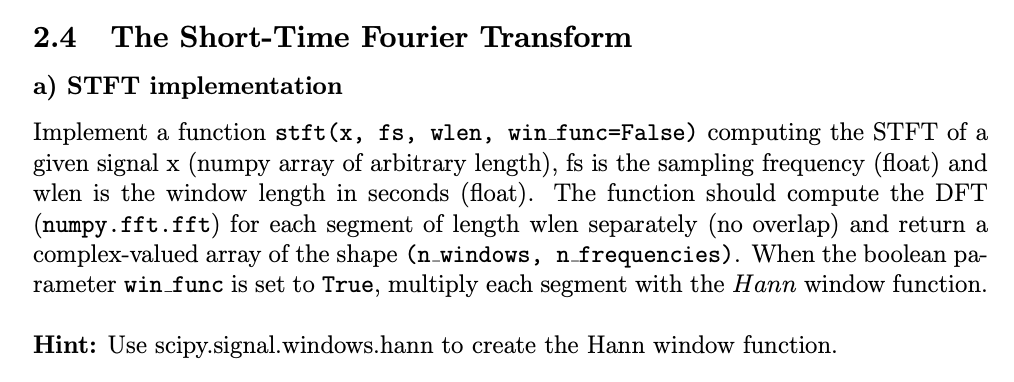

In [29]:
def stft(x, fs, wlen, win_func=False):
    N = len(x)
    L = int(wlen * fs)  # window length in samples
    n_windows = N // L
    stft_matrix = np.zeros((n_windows, L), dtype=complex)

    for i in range(n_windows):
        segment = x[i*L:(i+1)*L]
        if win_func:
            segment = segment * hann(L)
        stft_matrix[i] = np.fft.fft(segment)

    return stft_matrix

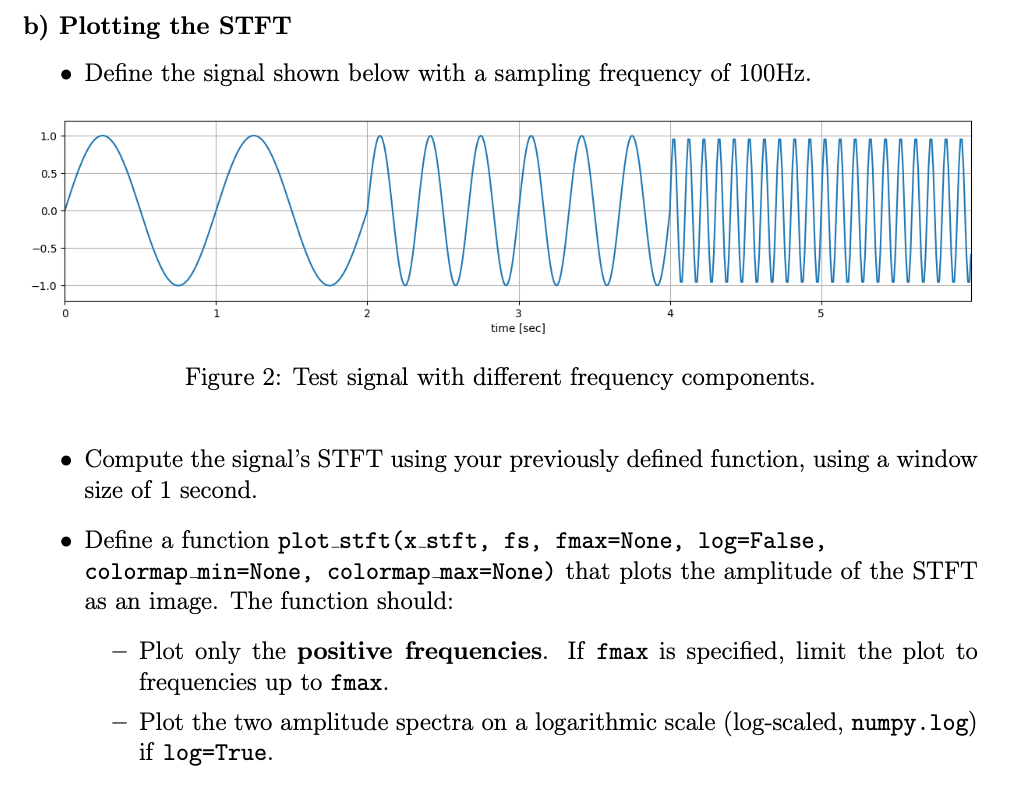
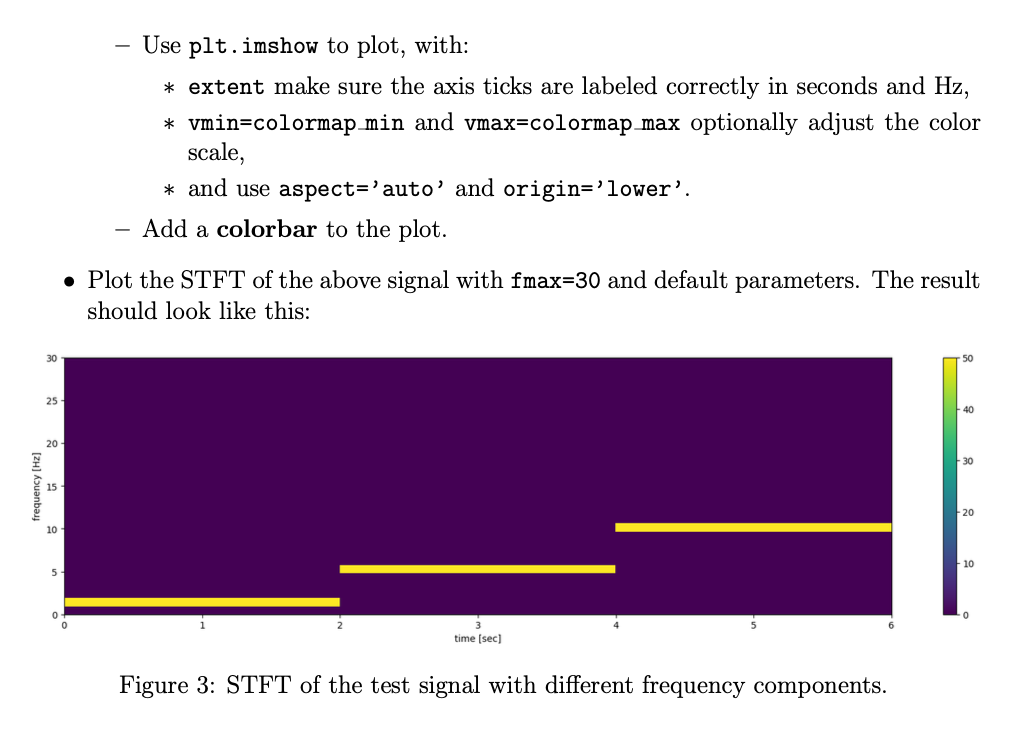

In [30]:
def plot_stft(x_stft, fs, fmax=None, log=False, colormap_min=None, colormap_max=None):
    n_windows, n_freqs = x_stft.shape
    f = np.fft.fftfreq(n_freqs, 1/fs)

    # keep only positive frequencies
    pos_idx = f >= 0
    f = f[pos_idx]
    x_stft = x_stft[:, pos_idx]

    if fmax is not None:
        f_idx = f <= fmax
        f = f[f_idx]
        x_stft = x_stft[:, f_idx]

    A = np.abs(x_stft.T)
    if log:
        A = np.log(A + 1e-10)

    extent = [0, n_windows, f[0], f[-1]]

    plt.figure(figsize=(10, 4))
    plt.imshow(A, extent=extent, aspect='auto', origin='lower',
               vmin=colormap_min, vmax=colormap_max)
    plt.colorbar()
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.title('STFT Magnitude')
    plt.tight_layout()
    plt.show()

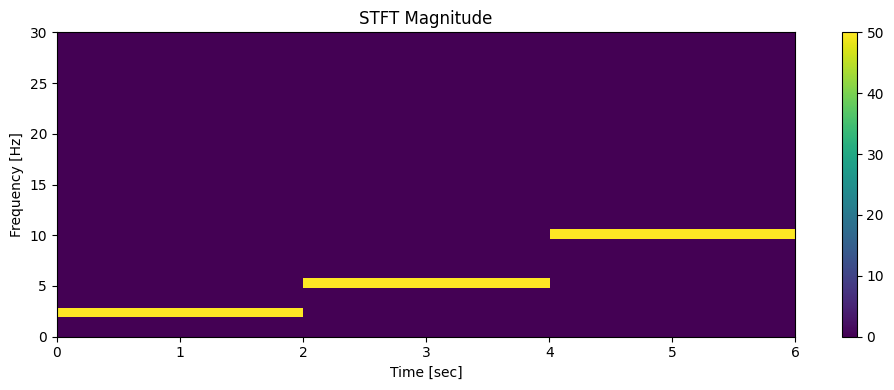

In [31]:
fs = 100
t = np.arange(0, 6, 1/fs)
x = np.concatenate([
    np.sin(2*np.pi*2*t[:2*fs]),
    np.sin(2*np.pi*5*t[2*fs:4*fs]),
    np.sin(2*np.pi*10*t[4*fs:])
])

X_stft = stft(x, fs, wlen=1, win_func=False)
plot_stft(X_stft, fs, fmax=30)

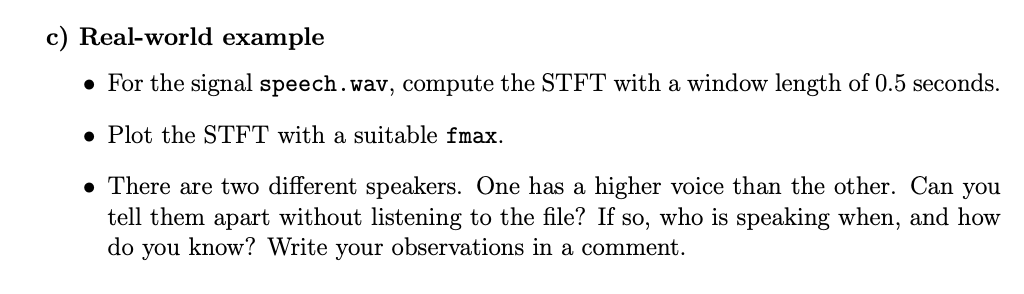

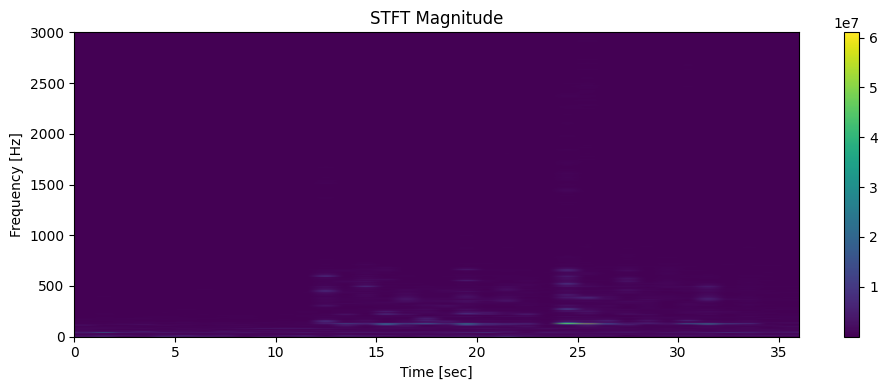

In [32]:
fs, x = wavfile.read("speech.wav")

X_stft = stft(x, fs, wlen=0.5, win_func=True)

plot_stft(X_stft, fs, fmax=3000)

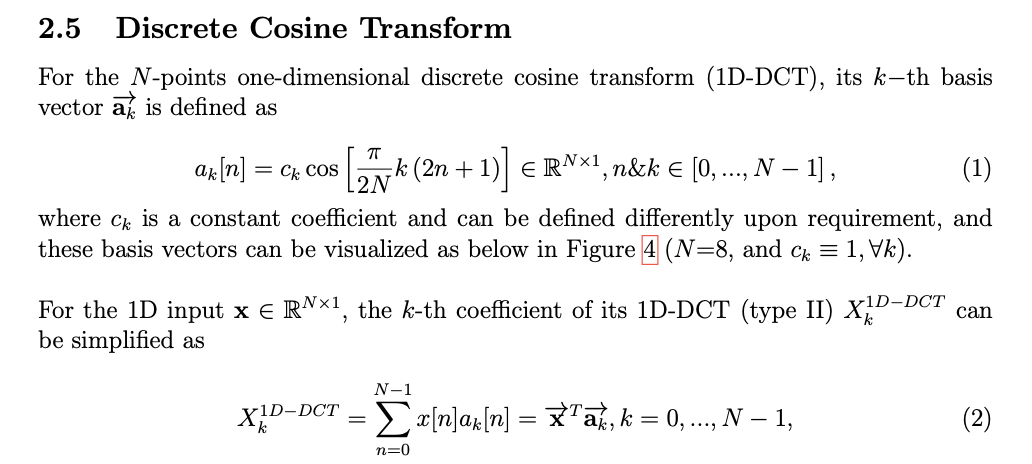
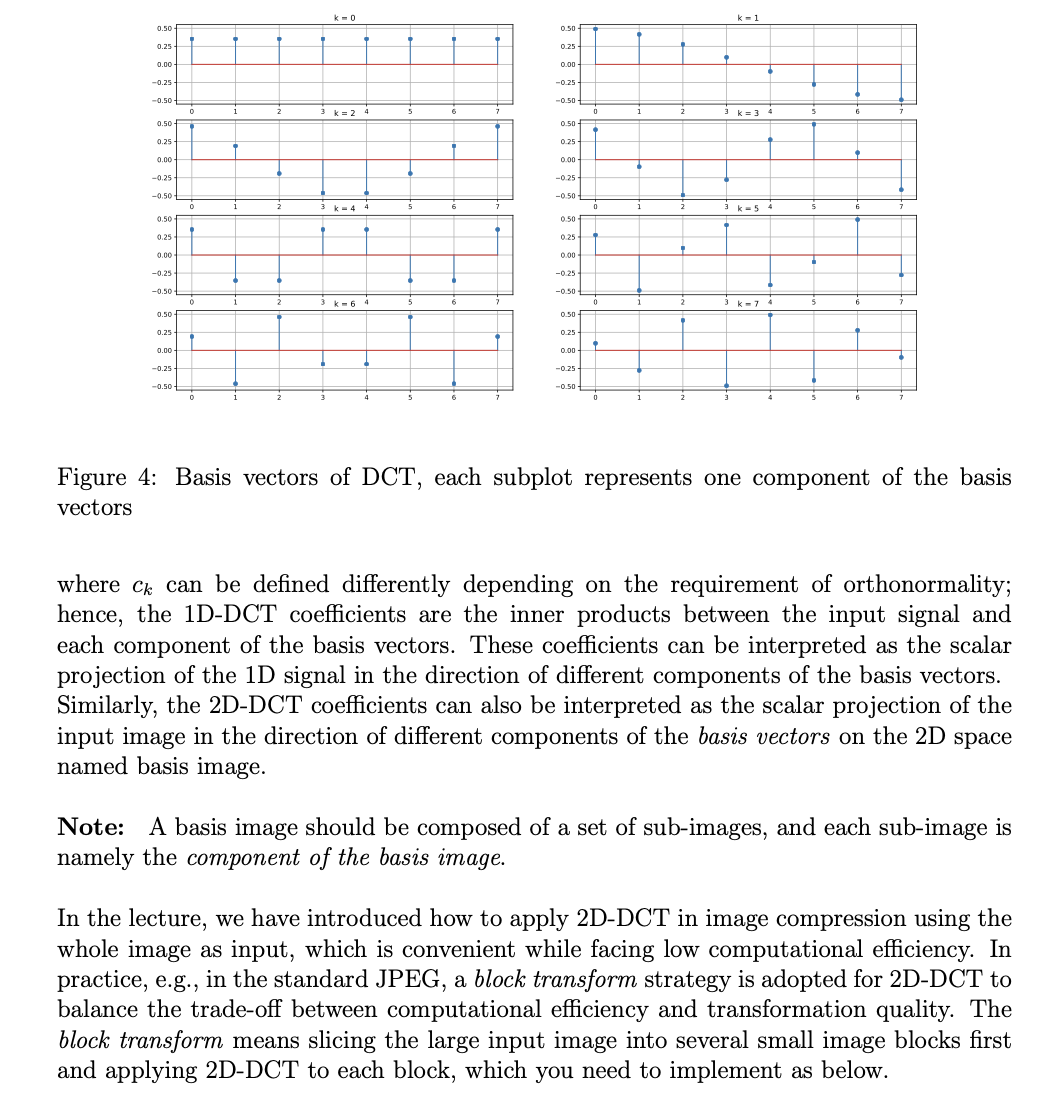

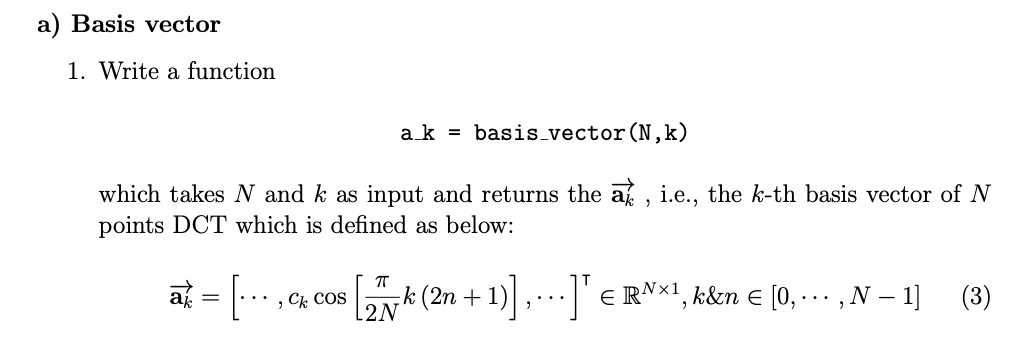
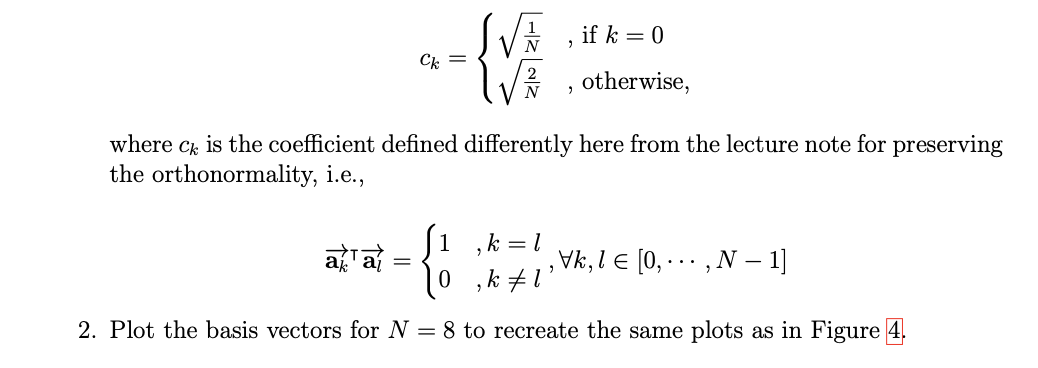

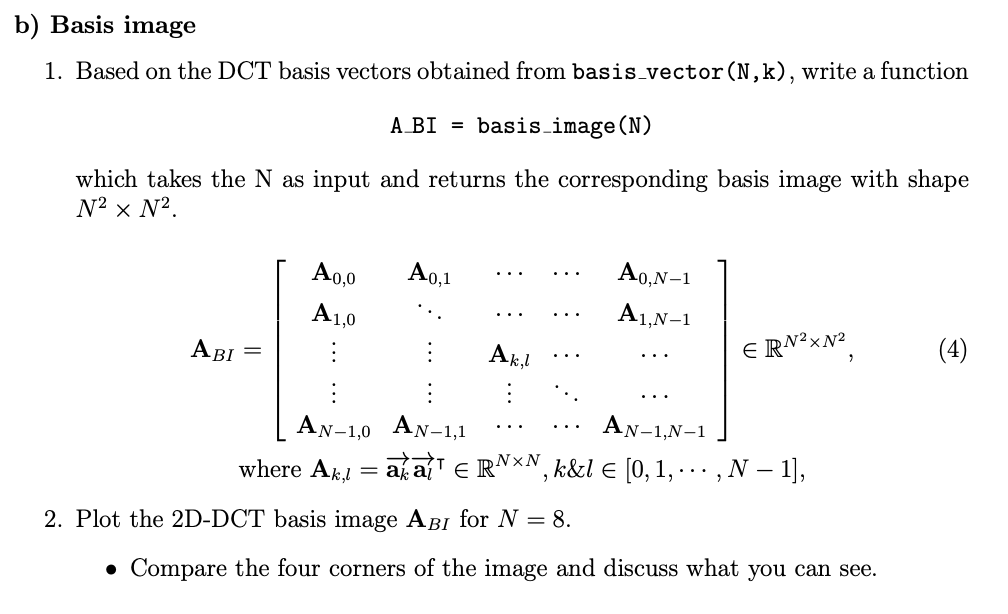

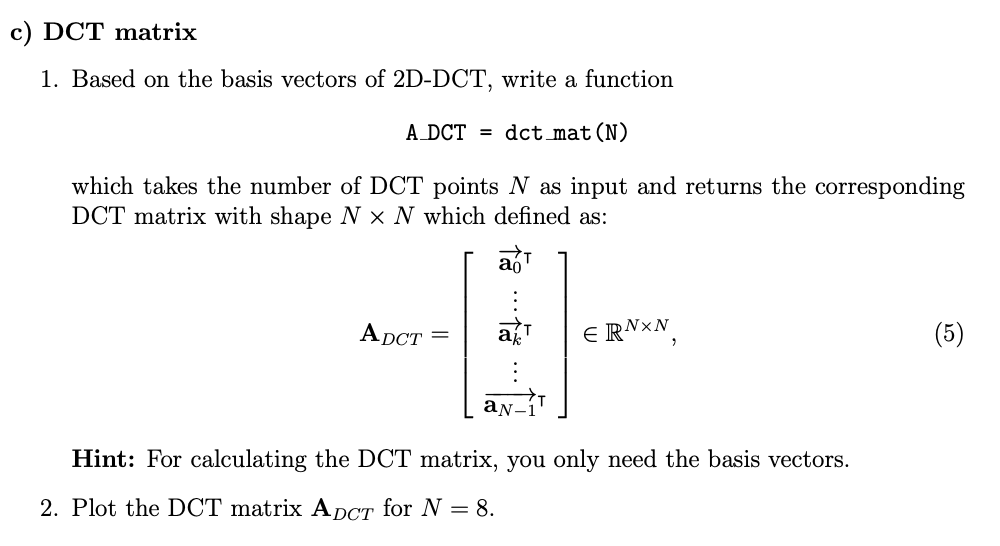

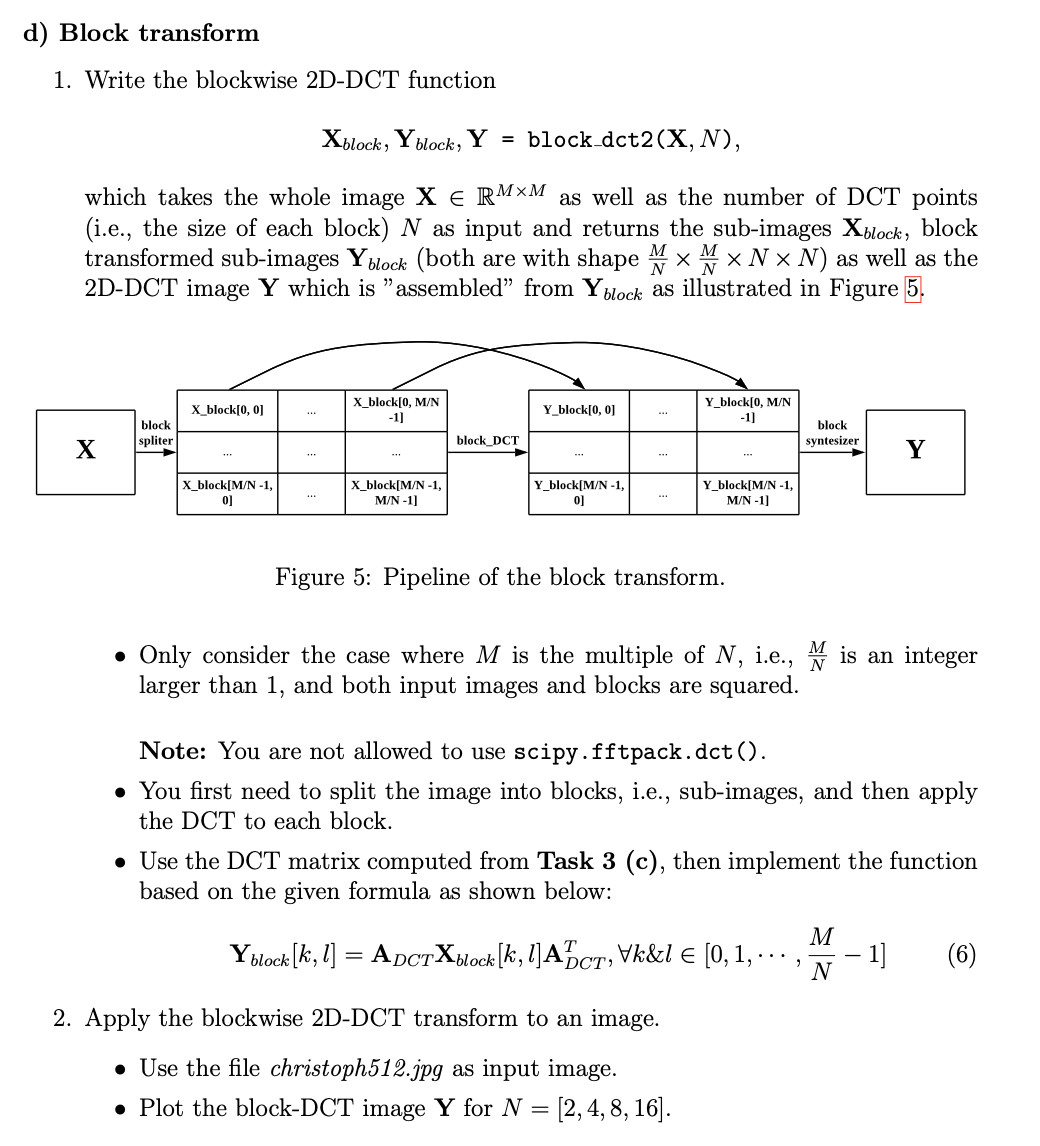

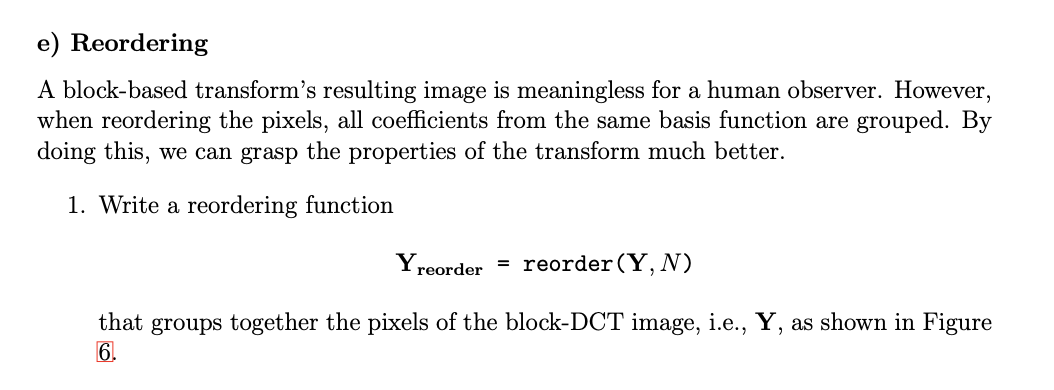
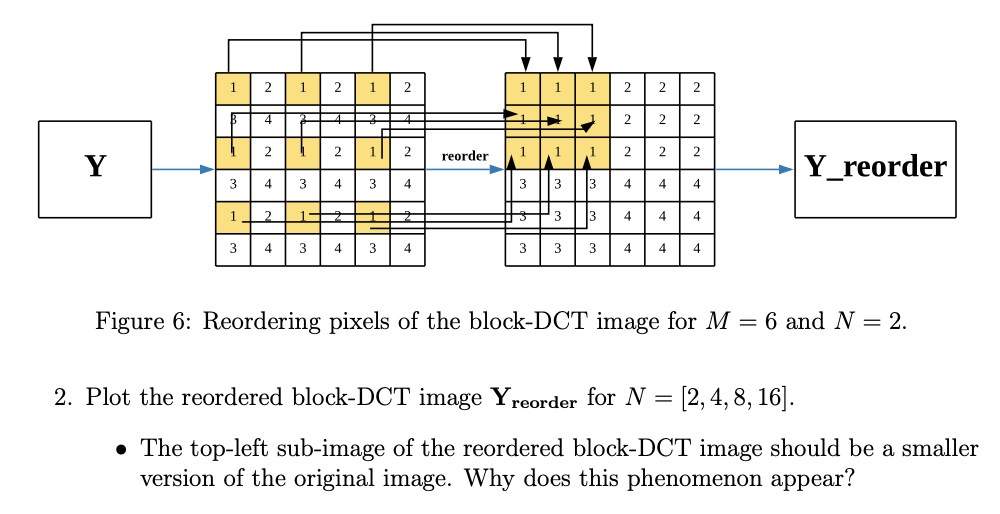

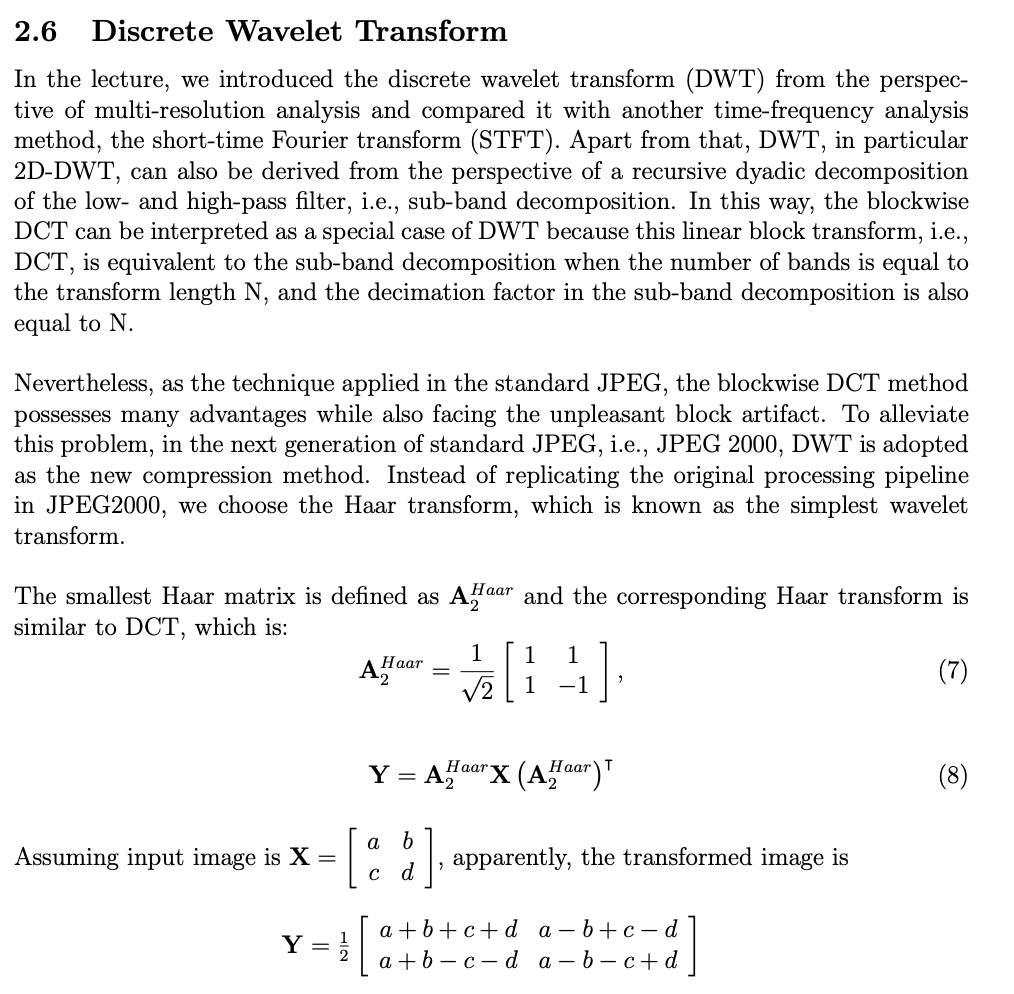
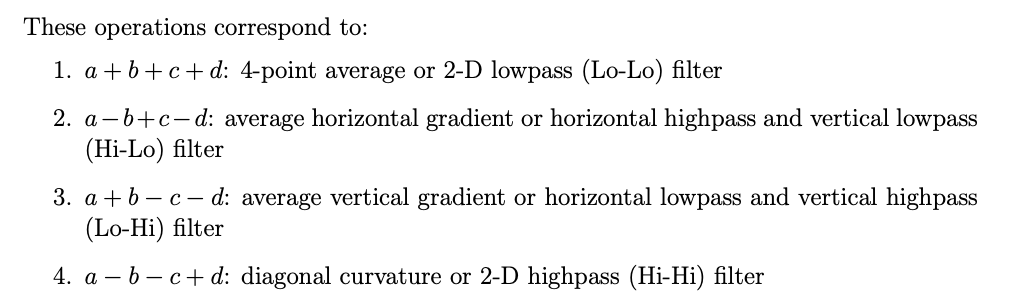

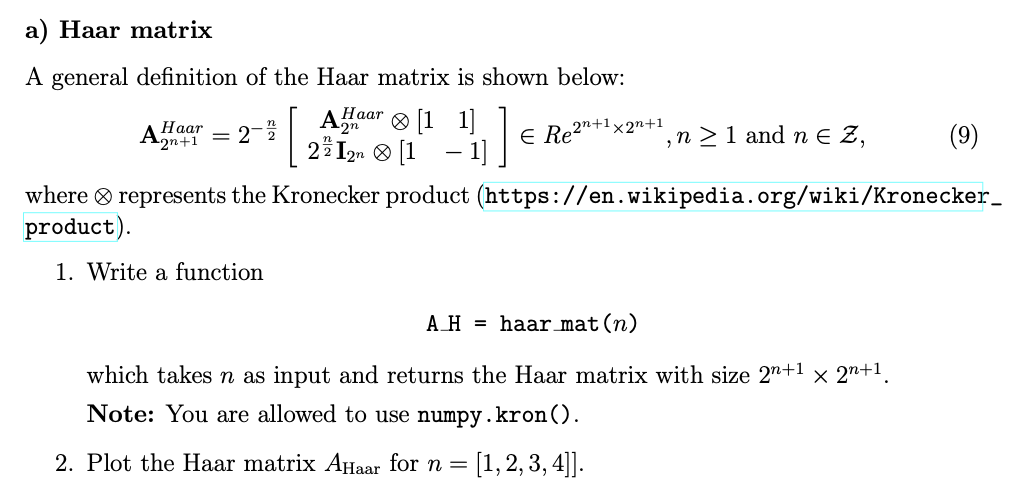

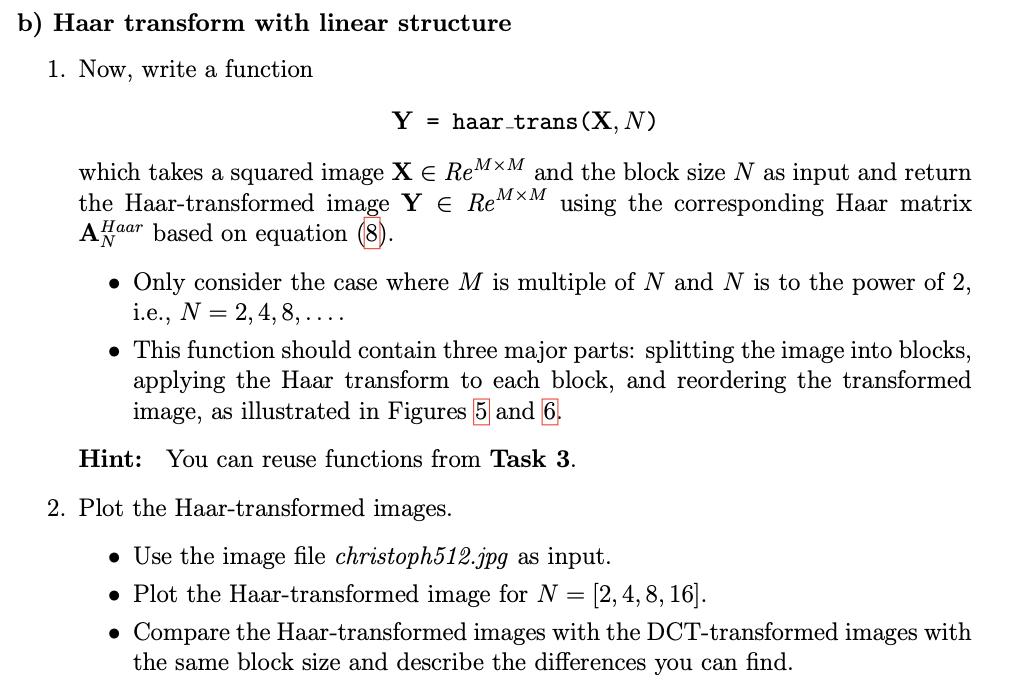

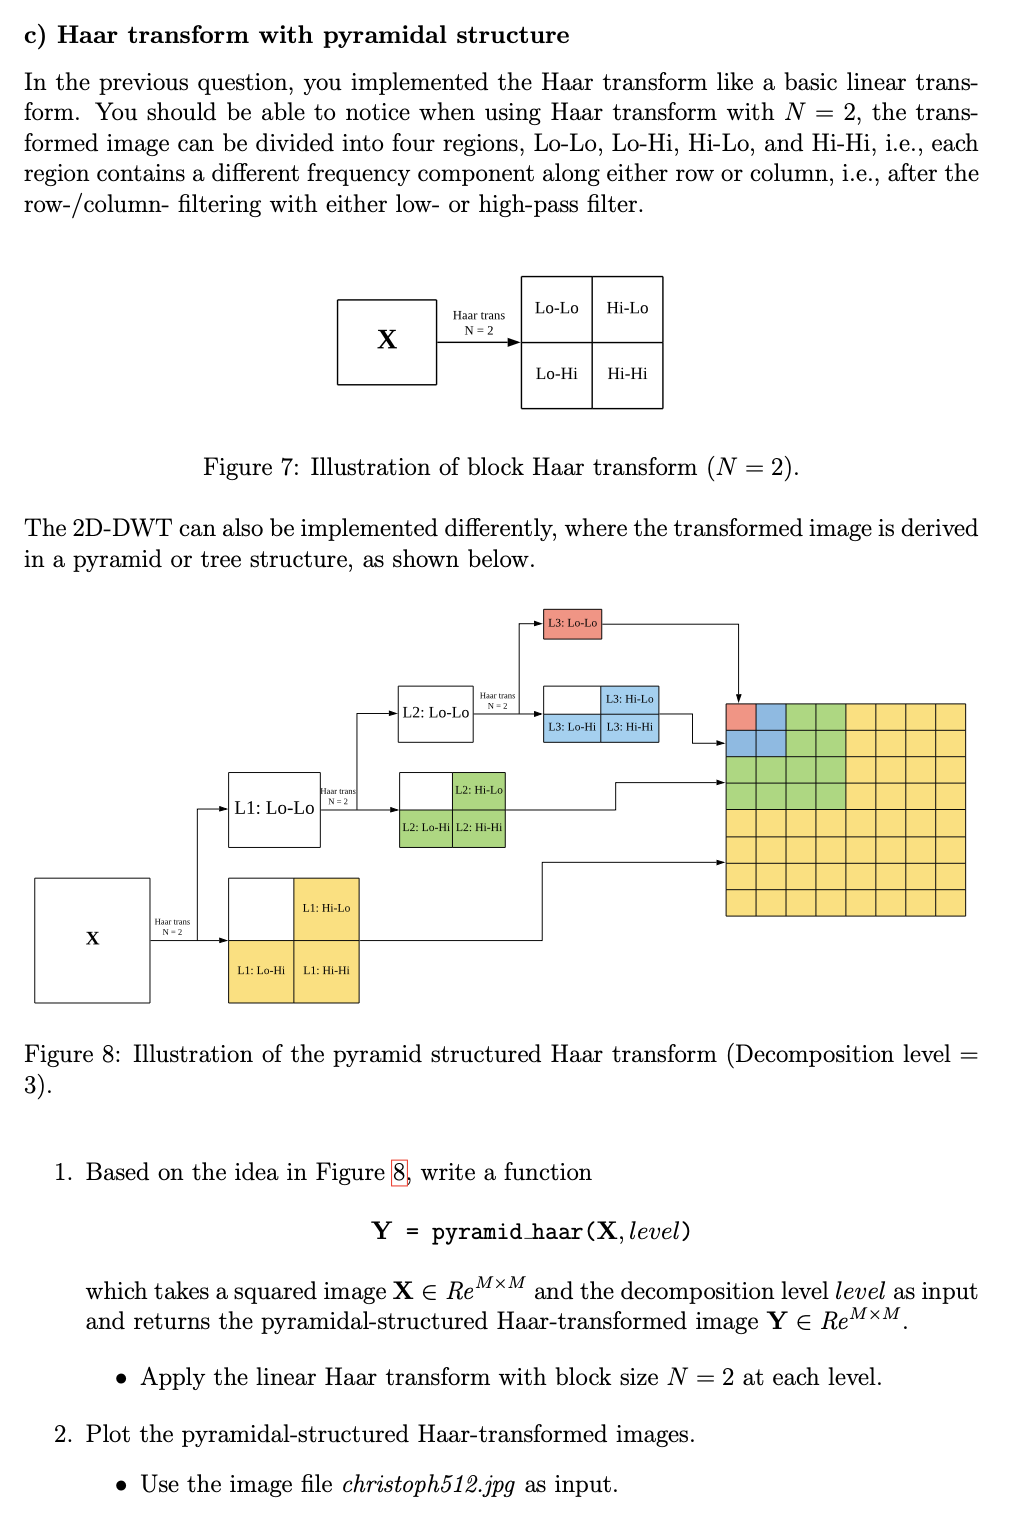
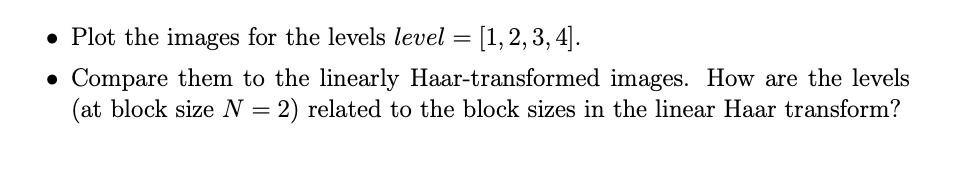

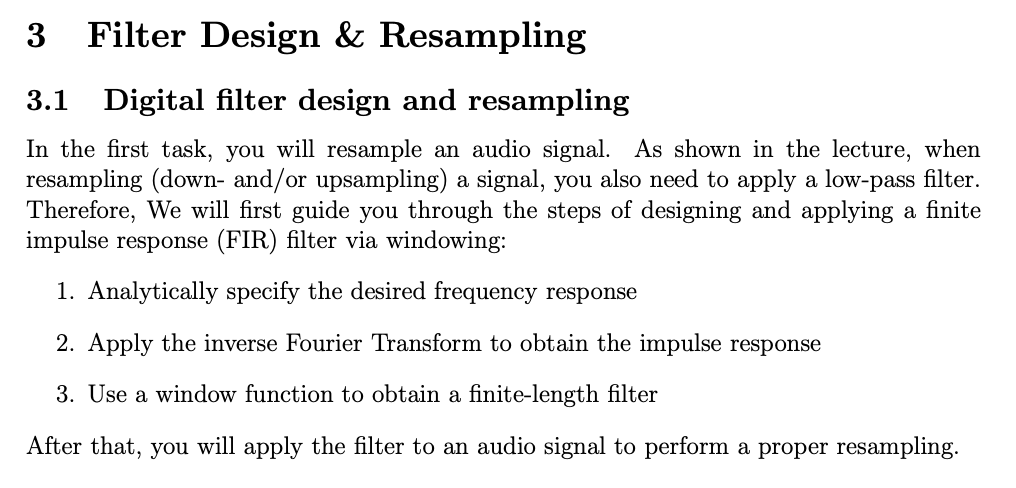

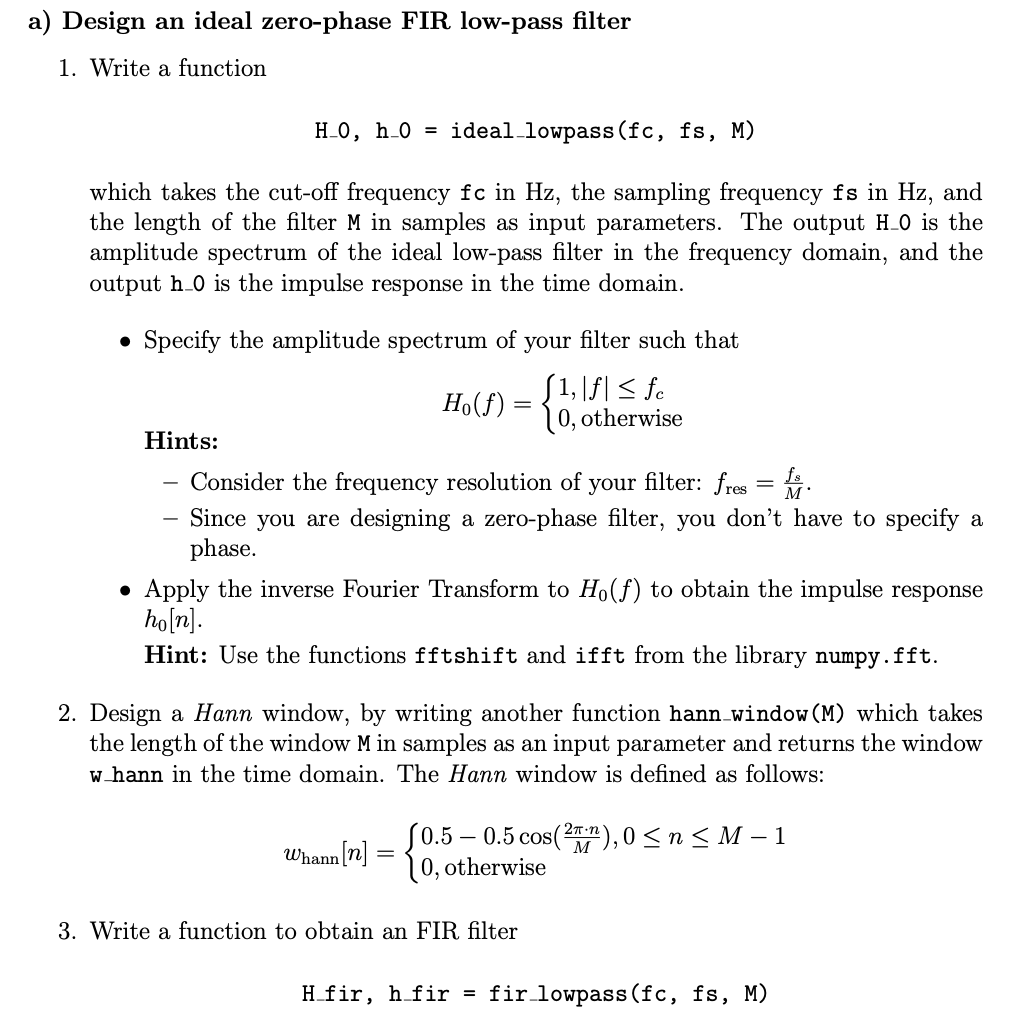
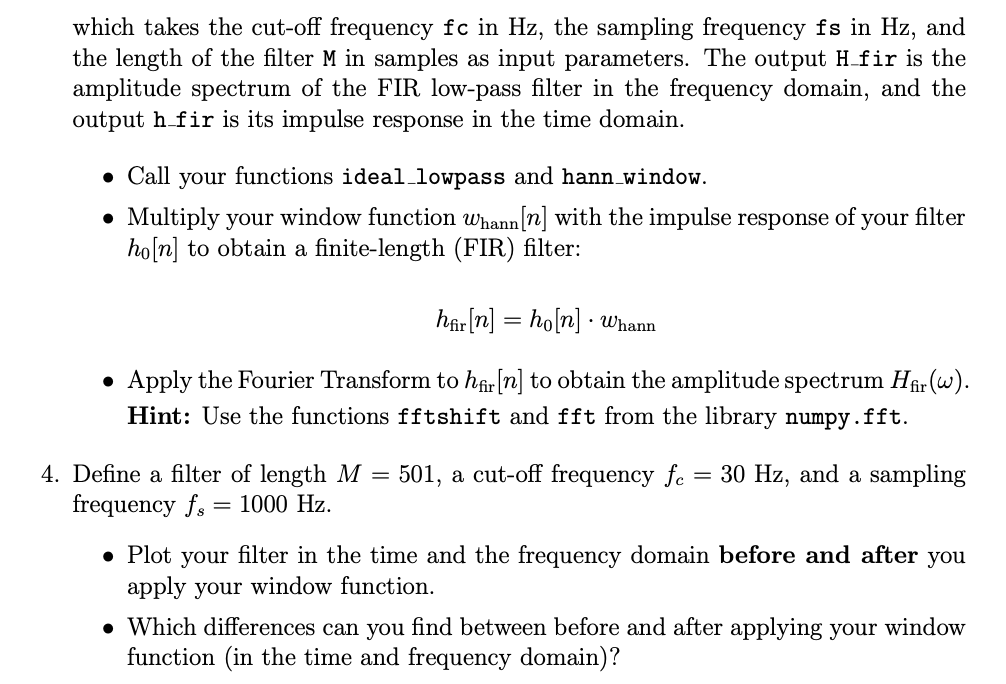

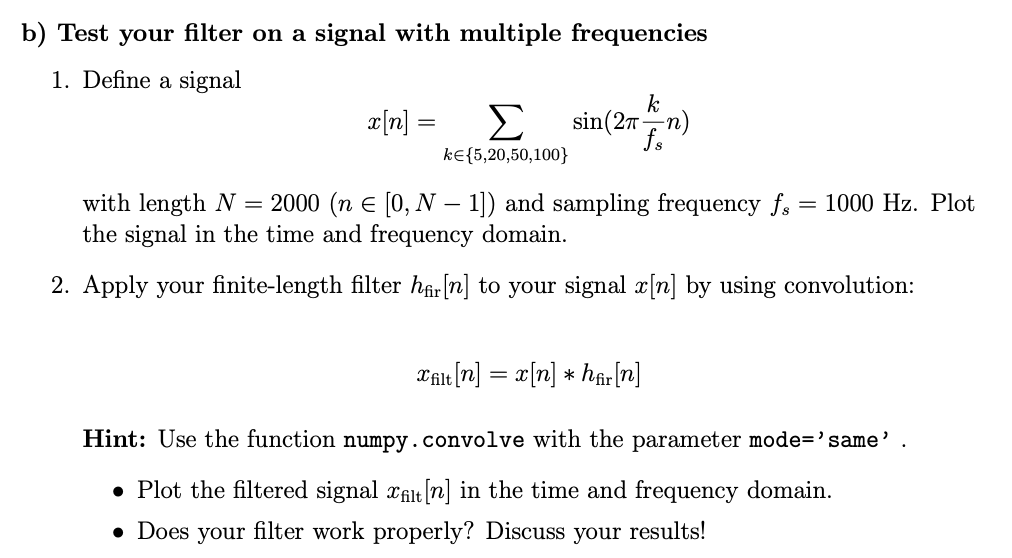

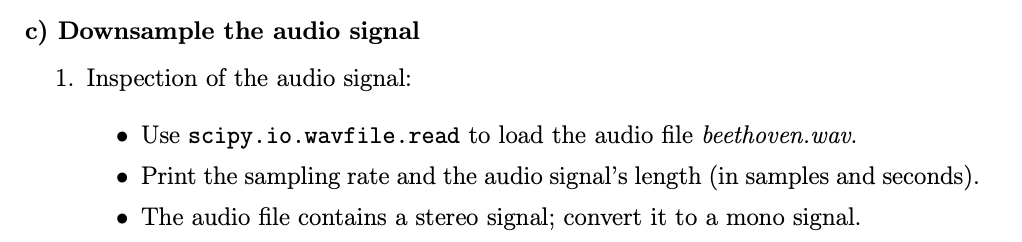
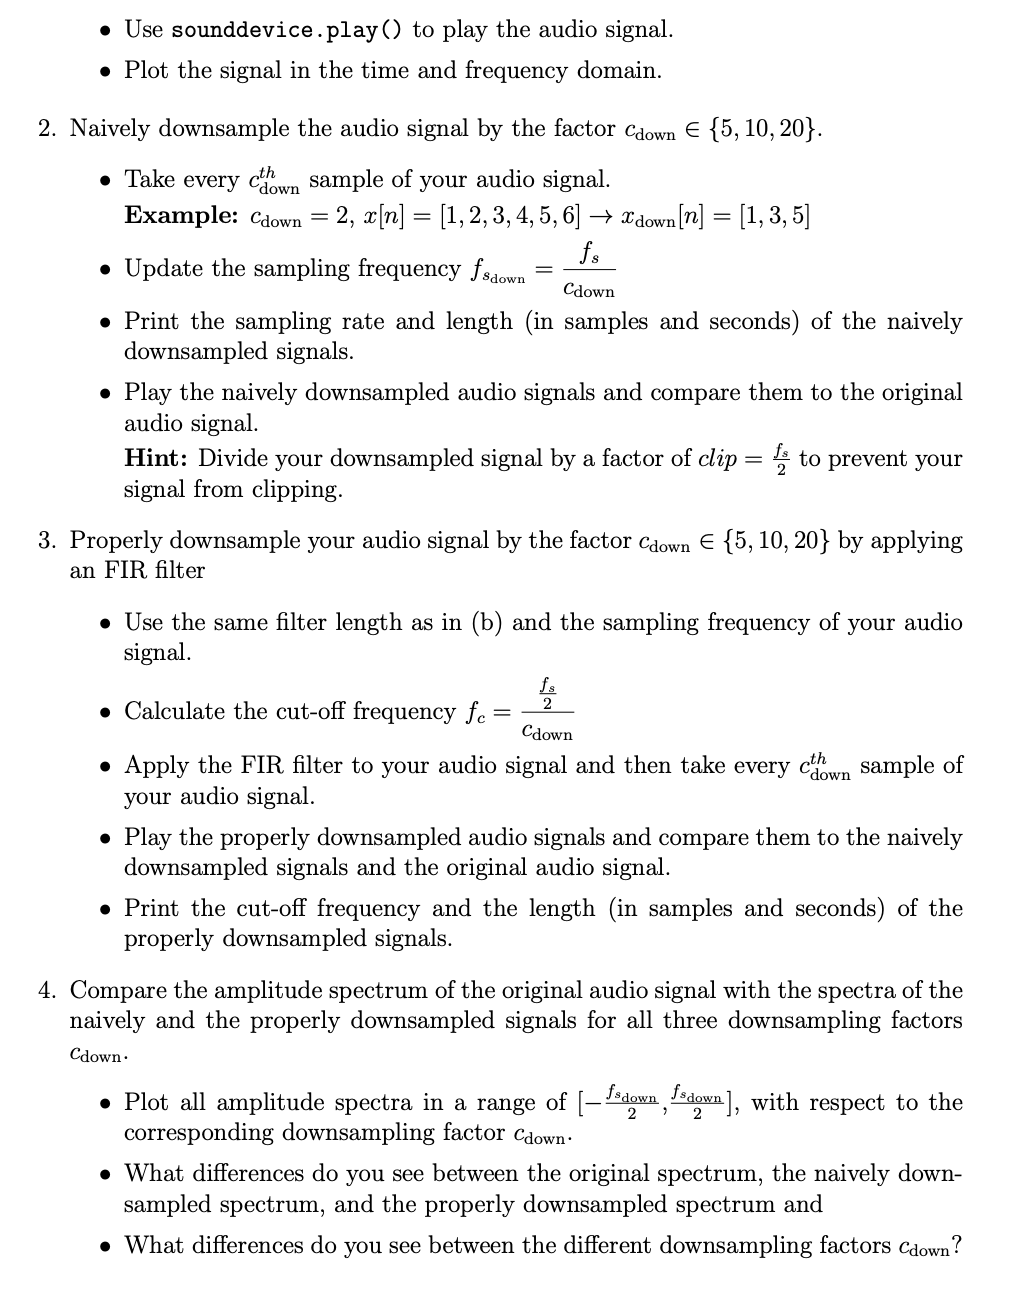

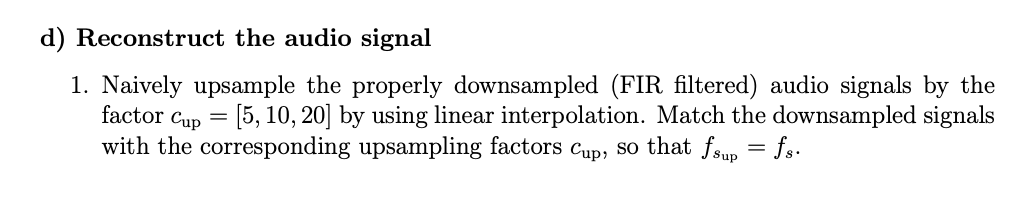
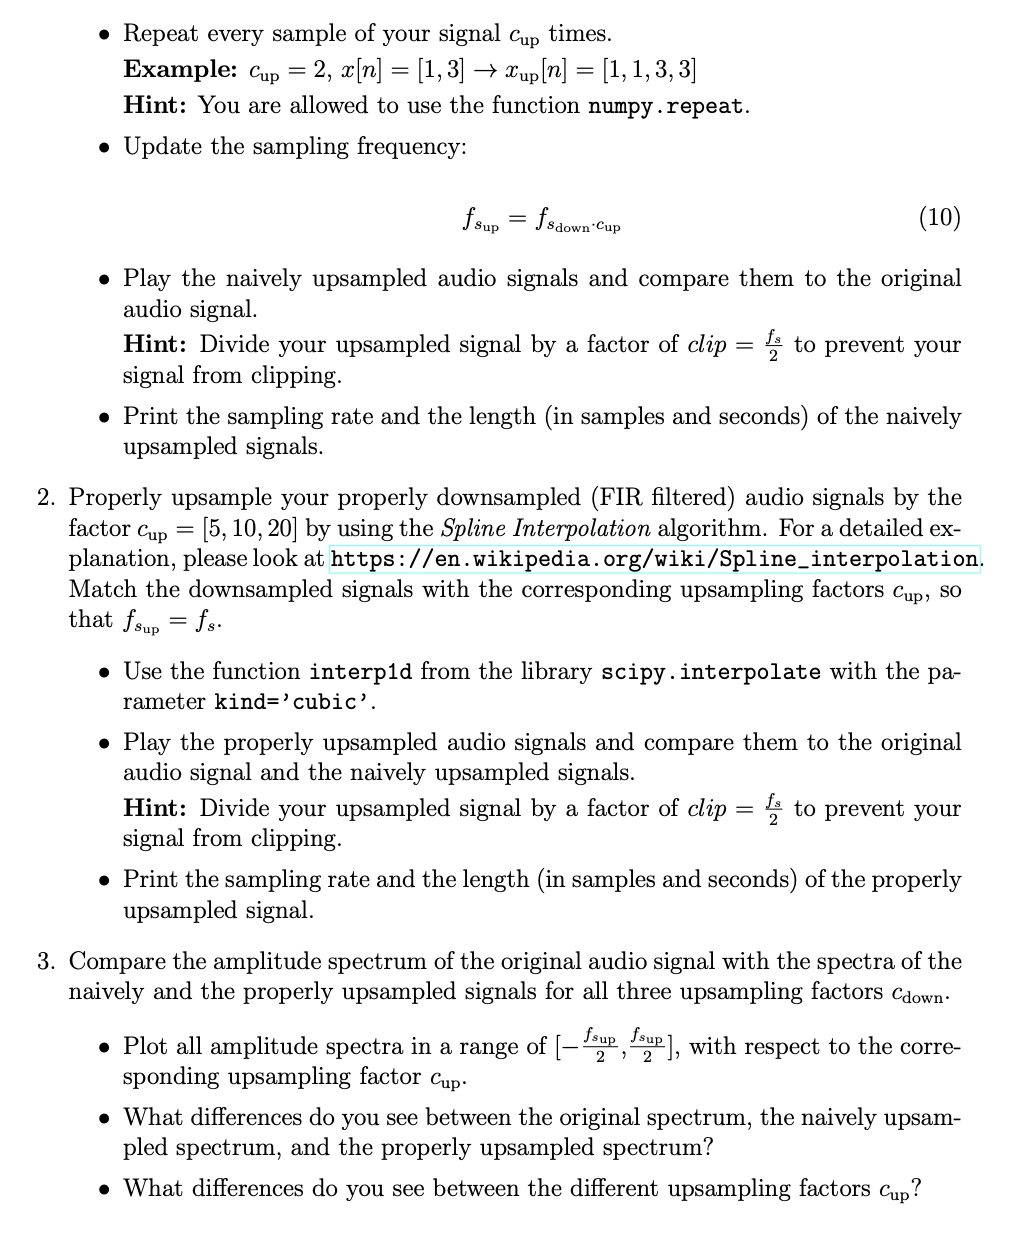